# Austin Housing Analysis: Time Series Forecasting

![Welcome to Austin](Data/Welcome-To-Austin.jpeg)

## 1. Overview

The year is 2018. A real estate investment firm in Austin, TX (ATX) is interested in making some investments for the upcoming year. They have hired us at Basilisk Analytics to determine which zip codes in the area represent good potential investment opportunities. In order to accomplish this, we will use time series forecasting to find the top 5 zip codes in the ATX region based on net profit & return on investment (ROI).

## 2. Business Problem

Our stakeholder is a real estate investment firm in ATX, and they have hired us at Basilisk Analytics to determine which zip codes in the area represent good potential investment opportunities. We will use time series forecasting to analyze median sale price for 73 zip codes in the ATX area to determine the 5 zip codes with the highest predicted net profit & ROI.

In [1]:
# Loading in Relevant Libraries:
import pandas as pd
import numpy as np
import pandas.tseries
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from pyzipcode import ZipCodeDatabase

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose


import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
!ls Data

Welcome-To-Austin.jpeg        zillow_data.csv
austin_area_zip_codes.geojson


## 3. Data Understanding

Our data comes from Zillow's database of median real estate prices organized by zip code (https://www.zillow.com/research/data/). This is a good dataset for our project because it includes all zip codes in the ATX region along with monthly median sale prices, which provides us with a lot of data points for time series modeling.

The original dataset included 14723 zip codes with 265 monthly median sale prices for each zip code. When we filtered our dataset to only include zip codes in Texas, there were 989 zip codes. Finally, after filtering for zip codes in the Austin area, we ended up with 73 zip codes.

The original dataset included dates as far back as April 1996, but we decided to filter out everything before January 2009. We made this choice to take the subprime mortgage housing crisis into account (essentially beginning our analysis right after the crash took place) because we figured that this event was an anomaly that could affect our model’s accuracy. After filtering out these dates, we had 112 monthly data points remaining in our set (January, 2009 through April, 2018).

Our final dataset thus has 73 zip codes and 112 months worth of median sale prices. All features in the dataset we used are median sale prices for real estate in each zip code by month, which is relevant because we are doing a time series analysis forecasting sale prices.

In [3]:
# Read the dataset
data = pd.read_csv('Data/zillow_data.csv')
data

RegionID  RegionName                 City State              Metro  \
0         84654       60657              Chicago    IL            Chicago   
1         90668       75070             McKinney    TX  Dallas-Fort Worth   
2         91982       77494                 Katy    TX            Houston   
3         84616       60614              Chicago    IL            Chicago   
4         93144       79936              El Paso    TX            El Paso   
...         ...         ...                  ...   ...                ...   
14718     58333        1338             Ashfield    MA    Greenfield Town   
14719     59107        3293            Woodstock    NH          Claremont   
14720     75672       40404                Berea    KY           Richmond   
14721     93733       81225  Mount Crested Butte    CO                NaN   
14722     95851       89155             Mesquite    NV          Las Vegas   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-07  \
0           Cook         1  334200.0  335400.0  336500.0  ...  1005500   
1         Collin         2  235700.0  236900.0  236700.0  ...   308000   
2         Harris         3  210400.0  212200.0  212200.0  ...   321000   
3           Cook         4  498100.0  500900.0  503100.0  ...  1289800   
4        El Paso         5   77300.0   77300.0   77300.0  ...   119100   
...          ...       ...       ...       ...       ...  ...      ...   
14718   Franklin     14719   94600.0   94300.0   94000.0  ...   216800   
14719    Grafton     14720   92700.0   92500.0   92400.0  ...   202100   
14720    Madison     14721   57100.0   57300.0   57500.0  ...   121800   
14721   Gunnison     14722  191100.0  192400.0  193700.0  ...   662800   
14722      Clark     14723  176400.0  176300.0  176100.0  ...   333800   

       2017-08  2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
0      1007500  1007800  1009600  1013300  1018700  1024400  1030700  1033800   
1       310000   312500   314100   315000   316600   318100   319600   321100   
2       320600   320200   320400   320800   321200   321200   323000   326900   
3      1287700  1287400  1291500  1296600  1299000  1302700  1306400  1308500   
4       119400   120000   120300   120300   120300   120300   120500   121000   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14718   217700   218600   218500   218100   216400   213100   209800   209200   
14719   208400   212200   215200   214300   213100   213700   218300   222700   
14720   122800   124600   126700   128800   130600   131700   132500   133000   
14721   671200   682400   695600   695500   694700   706400   705300   681500   
14722   336400   339700   343800   346800   348900   350400   353000   356000   

       2018-04  
0      1030600  
1       321800  
2       329900  
3      1307000  
4       121500  
...        ...  
14718   209300  
14719   225800  
14720   133400  
14721   664400  
14722   357200  

[14723 rows x 272 columns]

In [4]:
# Look into Texas state:
texas_data= data[data['State'] == 'TX']
texas_data

RegionID  RegionName           City State              Metro  \
1         90668       75070       McKinney    TX  Dallas-Fort Worth   
2         91982       77494           Katy    TX            Houston   
4         93144       79936        El Paso    TX            El Paso   
5         91733       77084        Houston    TX            Houston   
8         91940       77449           Katy    TX            Houston   
...         ...         ...            ...   ...                ...   
14372     91640       76941        Mertzon    TX         San Angelo   
14472     92897       79313          Anton    TX          Levelland   
14492     92921       79355         Plains    TX                NaN   
14599     92929       79366  Ransom Canyon    TX            Lubbock   
14695     91948       77457      Matagorda    TX           Bay City   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-07  \
1         Collin         2  235700.0  236900.0  236700.0  ...   308000   
2         Harris         3  210400.0  212200.0  212200.0  ...   321000   
4        El Paso         5   77300.0   77300.0   77300.0  ...   119100   
5         Harris         6   95000.0   95200.0   95400.0  ...   157900   
8         Harris         9   95400.0   95600.0   95800.0  ...   166800   
...          ...       ...       ...       ...       ...  ...      ...   
14372      Irion     14373       NaN       NaN       NaN  ...   122500   
14472    Hockley     14473       NaN       NaN       NaN  ...    55400   
14492     Yoakum     14493       NaN       NaN       NaN  ...   100500   
14599    Lubbock     14600  134500.0  134500.0  134400.0  ...   252100   
14695  Matagorda     14696   90700.0   91000.0   91200.0  ...   250400   

       2017-08  2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
1       310000   312500   314100   315000   316600   318100   319600   321100   
2       320600   320200   320400   320800   321200   321200   323000   326900   
4       119400   120000   120300   120300   120300   120300   120500   121000   
5       158700   160200   161900   162800   162800   162800   162900   163500   
8       167400   168400   169600   170900   172300   173300   174200   175400   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14372   121800   121600   122200   123500   124700   124300   122600   121600   
14472    56300    55700    56300    58900    61500    63000    63600    63500   
14492   100500   101000   100700    99700    97700    95800    94600    94000   
14599   251600   251600   251500   251300   251500   251700   252500   255000   
14695   253300   256900   256100   250700   243200   238300   234200   230500   

       2018-04  
1       321800  
2       329900  
4       121500  
5       164300  
8       176200  
...        ...  
14372   121600  
14472    63300  
14492    93500  
14599   257500  
14695   227300  

[989 rows x 272 columns]

In [5]:
# Look into Austin metro area:
austin = texas_data[texas_data['Metro'] == 'Austin'].sort_values(by = 'RegionName')
austin

RegionID  RegionName         City State   Metro  CountyName  SizeRank  \
12908     91454       76530      Granger    TX  Austin  Williamson     12909   
6028      91486       76574       Taylor    TX  Austin  Williamson      6029   
3575      92541       78602      Bastrop    TX  Austin     Bastrop      3576   
2382      92548       78610         Buda    TX  Austin        Hays      2383   
7699      92550       78612  Cedar Creek    TX  Austin     Bastrop      7700   
...         ...         ...          ...   ...     ...         ...       ...   
8022      92665       78756       Austin    TX  Austin      Travis      8023   
3885      92666       78757       Austin    TX  Austin      Travis      3886   
422       92667       78758       Austin    TX  Austin      Travis       423   
507       92668       78759       Austin    TX  Austin      Travis       508   
8270      92750       78957   Smithville    TX  Austin     Bastrop      8271   

        1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  2017-10  \
12908       NaN       NaN       NaN  ...   150300   149100   149600   147800   
6028    85900.0   86100.0   86300.0  ...   167500   168200   169300   169800   
3575    74400.0   74700.0   75100.0  ...   185800   189600   193100   194100   
2382   149200.0  148600.0  148200.0  ...   256300   256100   256800   257900   
7699    76500.0   76300.0   76100.0  ...   193500   196500   199900   201800   
...         ...       ...       ...  ...      ...      ...      ...      ...   
8022   194900.0  196500.0  198100.0  ...   471500   471500   472100   473600   
3885   150300.0  150900.0  152100.0  ...   418200   415600   413600   413900   
422    129000.0  128300.0  127500.0  ...   250000   248400   247500   247400   
507    266400.0  269000.0  272000.0  ...   429700   431100   433000   435800   
8270    48500.0   48600.0   48800.0  ...   138400   141200   143900   145000   

       2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
12908   145200   144700   145500   152600   161700   163800  
6028    170700   171800   173100   173900   174200   173700  
3575    192600   191700   191400   192000   194700   197500  
2382    258700   258000   256900   257200   258900   260000  
7699    201400   200700   200600   203000   208100   212400  
...        ...      ...      ...      ...      ...      ...  
8022    475100   476000   476600   478700   483400   487400  
3885    416400   420600   424000   426300   427900   428500  
422     247900   250500   255100   260100   266000   270400  
507     439400   442400   443200   445000   449900   454100  
8270    144900   145400   146300   148400   152400   155100  

[73 rows x 272 columns]

In [6]:
# Explore numerical columns:
austin.describe()

RegionID    RegionName      SizeRank        1996-04  \
count      73.000000     73.000000     73.000000      71.000000   
mean   100998.479452  78639.493151   4865.986301  182170.422535   
std     50469.701280    357.603603   3421.088657  123021.197238   
min     91454.000000  76530.000000     19.000000   25000.000000   
25%     92580.000000  78644.000000   2383.000000  104550.000000   
50%     92633.000000  78717.000000   4849.000000  150300.000000   
75%     92651.000000  78738.000000   6893.000000  207050.000000   
max    399638.000000  78957.000000  12909.000000  772100.000000   

             1996-05        1996-06        1996-07        1996-08  \
count      71.000000      71.000000      71.000000      71.000000   
mean   181991.549296  181921.126761  181953.521127  182070.422535   
std    122484.390547  122047.840638  121678.979087  121413.278156   
min     25200.000000   25500.000000   25800.000000   26100.000000   
25%    104300.000000  104150.000000  104000.000000  103900.000000   
50%    150200.000000  150300.000000  150600.000000  151000.000000   
75%    207150.000000  207550.000000  208050.000000  208850.000000   
max    765800.000000  760200.000000  755200.000000  751100.000000   

             1996-09        1996-10  ...        2017-07        2017-08  \
count      71.000000      71.000000  ...      73.000000      73.000000   
mean   182259.154930  182481.690141  ...  322747.945205  323019.178082   
std    121220.877006  121101.231927  ...  154902.910551  153795.172820   
min     26400.000000   26800.000000  ...  101200.000000  102000.000000   
25%    103900.000000  103950.000000  ...  206500.000000  209300.000000   
50%    151500.000000  151800.000000  ...  291400.000000  290700.000000   
75%    209650.000000  210350.000000  ...  418200.000000  415600.000000   
max    747800.000000  745500.000000  ...  910500.000000  900700.000000   

             2017-09        2017-10        2017-11        2017-12  \
count      73.000000      73.000000      73.000000      73.000000   
mean   323705.479452  325069.863014  326483.561644  327635.616438   
std    152940.406777  153563.171660  154465.828668  154833.348017   
min    102400.000000  102300.000000  102400.000000  103000.000000   
25%    212300.000000  215000.000000  216500.000000  217100.000000   
50%    289600.000000  289600.000000  291300.000000  294000.000000   
75%    413600.000000  413900.000000  416400.000000  420600.000000   
max    895800.000000  900200.000000  905500.000000  909000.000000   

             2018-01        2018-02        2018-03        2018-04  
count      73.000000      73.000000      73.000000      73.000000  
mean   328550.684932  330754.794521  334575.342466  337193.150685  
std    155038.873372  155803.148628  157340.422493  158361.672314  
min    103300.000000  104100.000000  105900.000000  107000.000000  
25%    217700.000000  219500.000000  221600.000000  222300.000000  
50%    295900.000000  297800.000000  297500.000000  297300.000000  
75%    424000.000000  426300.000000  433200.000000  438700.000000  
max    912600.000000  917200.000000  921200.000000  918700.000000  

[8 rows x 268 columns]

In [7]:
# Explore object columns:
austin[[c for c in austin.columns if austin[c].dtype =='object']].describe()

City State   Metro CountyName
count       73    73      73         73
unique      31     1       1          5
top     Austin    TX  Austin     Travis
freq        38    73      73         45

## 4. Data Preprocessing

As discussed above, we began by filtering the full Zillow dataset to only include ATX zip codes and dates from January, 2009–April, 2018. We also used a “melt” function that converts the original Zillow dataset from wide- to long-form, sets a DatetimeIndex using each month as a new row (rather than column as in the original dataset), sets each column as a unique zip code (original column ‘RegionName’), and includes the median sale price for that month as each value. Using a DatetimeIndex makes time series modeling much more effective, and only including the median sale price for each month in each zip code leaves only the most essential information for our analysis. 

In [8]:
# This function is provided with the starter notebook:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [9]:
# Melting data for each zipcode in Austin metro area, and concatenate into a new dataframe:
df = pd.DataFrame()
for i in austin['RegionName']:
    x = melt_data(austin[austin['RegionName'] == i])  
    df = pd.concat([df, x], axis=1)
    df.rename(columns = {'value':i}, inplace = True)

# Look into the new dataframe
df

76530     76574     78602     78610     78612     78613  \
time                                                                     
1996-04-01       NaN   85900.0   74400.0  149200.0   76500.0  169600.0   
1996-05-01       NaN   86100.0   74700.0  148600.0   76300.0  169000.0   
1996-06-01       NaN   86300.0   75100.0  148200.0   76100.0  168600.0   
1996-07-01       NaN   86500.0   75700.0  148100.0   76000.0  168500.0   
1996-08-01       NaN   86600.0   76200.0  148100.0   75900.0  168700.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  144700.0  171800.0  191700.0  258000.0  200700.0  296200.0   
2018-01-01  145500.0  173100.0  191400.0  256900.0  200600.0  295900.0   
2018-02-01  152600.0  173900.0  192000.0  257200.0  203000.0  296400.0   
2018-03-01  161700.0  174200.0  194700.0  258900.0  208100.0  297500.0   
2018-04-01  163800.0  173700.0  197500.0  260000.0  212400.0  297300.0   

               78616     78617     78619     78620  ...     78750     78751  \
time                                                ...                       
1996-04-01       NaN  121900.0  298000.0  213300.0  ...  266200.0  115900.0   
1996-05-01       NaN  120500.0  298000.0  213300.0  ...  267800.0  116900.0   
1996-06-01       NaN  119000.0  297900.0  213400.0  ...  269500.0  118000.0   
1996-07-01       NaN  117400.0  297800.0  213400.0  ...  271100.0  119100.0   
1996-08-01       NaN  116000.0  297700.0  213400.0  ...  272600.0  120200.0   
...              ...       ...       ...       ...  ...       ...       ...   
2017-12-01  137000.0  182100.0  479400.0  417900.0  ...  437100.0  434500.0   
2018-01-01  136800.0  183100.0  478100.0  420900.0  ...  439100.0  436100.0   
2018-02-01  138500.0  184300.0  482100.0  425800.0  ...  442400.0  437600.0   
2018-03-01  143000.0  186000.0  497500.0  433200.0  ...  446100.0  441200.0   
2018-04-01  145900.0  187100.0  513000.0  438700.0  ...  448200.0  444500.0   

               78752     78753     78754     78756     78757     78758  \
time                                                                     
1996-04-01   87200.0  111300.0  133100.0  194900.0  150300.0  129000.0   
1996-05-01   87000.0  110600.0  132900.0  196500.0  150900.0  128300.0   
1996-06-01   86800.0  109900.0  132800.0  198100.0  152100.0  127500.0   
1996-07-01   86700.0  109200.0  132600.0  199700.0  153600.0  126900.0   
1996-08-01   86500.0  108600.0  132500.0  201200.0  155300.0  126300.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  299300.0  225000.0  235500.0  476000.0  420600.0  250500.0   
2018-01-01  300400.0  227100.0  235100.0  476600.0  424000.0  255100.0   
2018-02-01  301400.0  228700.0  235700.0  478700.0  426300.0  260100.0   
2018-03-01  302300.0  231500.0  238300.0  483400.0  427900.0  266000.0   
2018-04-01  303100.0  233400.0  240600.0  487400.0  428500.0  270400.0   

               78759     78957  
time                            
1996-04-01  266400.0   48500.0  
1996-05-01  269000.0   48600.0  
1996-06-01  272000.0   48800.0  
1996-07-01  275100.0   48900.0  
1996-08-01  278200.0   49100.0  
...              ...       ...  
2017-12-01  442400.0  145400.0  
2018-01-01  443200.0  146300.0  
2018-02-01  445000.0  148400.0  
2018-03-01  449900.0  152400.0  
2018-04-01  454100.0  155100.0  

[265 rows x 73 columns]

In [10]:
# Filter time from January 2009 to April 2018: 
df_final = df[df.index.year > 2008]
df_final

76530     76574     78602     78610     78612     78613  \
time                                                                     
2009-01-01  110700.0  112200.0  123000.0  190200.0  128500.0  205300.0   
2009-02-01  111100.0  112200.0  122400.0  189500.0  127700.0  205000.0   
2009-03-01  111800.0  112300.0  121700.0  188800.0  127000.0  204700.0   
2009-04-01  112600.0  112400.0  121000.0  188100.0  126100.0  204600.0   
2009-05-01  113100.0  112400.0  120200.0  187500.0  125200.0  204300.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  144700.0  171800.0  191700.0  258000.0  200700.0  296200.0   
2018-01-01  145500.0  173100.0  191400.0  256900.0  200600.0  295900.0   
2018-02-01  152600.0  173900.0  192000.0  257200.0  203000.0  296400.0   
2018-03-01  161700.0  174200.0  194700.0  258900.0  208100.0  297500.0   
2018-04-01  163800.0  173700.0  197500.0  260000.0  212400.0  297300.0   

               78616     78617     78619     78620  ...     78750     78751  \
time                                                ...                       
2009-01-01   92900.0  131400.0  383600.0  287000.0  ...  304700.0  304400.0   
2009-02-01   92200.0  130800.0  381300.0  284900.0  ...  304400.0  303300.0   
2009-03-01   91600.0  130100.0  379400.0  283100.0  ...  304000.0  302400.0   
2009-04-01   91000.0  129300.0  378300.0  281400.0  ...  303500.0  301400.0   
2009-05-01   90400.0  128600.0  377400.0  279800.0  ...  302800.0  300200.0   
...              ...       ...       ...       ...  ...       ...       ...   
2017-12-01  137000.0  182100.0  479400.0  417900.0  ...  437100.0  434500.0   
2018-01-01  136800.0  183100.0  478100.0  420900.0  ...  439100.0  436100.0   
2018-02-01  138500.0  184300.0  482100.0  425800.0  ...  442400.0  437600.0   
2018-03-01  143000.0  186000.0  497500.0  433200.0  ...  446100.0  441200.0   
2018-04-01  145900.0  187100.0  513000.0  438700.0  ...  448200.0  444500.0   

               78752     78753     78754     78756     78757     78758  \
time                                                                     
2009-01-01  182400.0  135000.0  173100.0  337800.0  272100.0  143400.0   
2009-02-01  182600.0  134900.0  172600.0  335600.0  271600.0  143400.0   
2009-03-01  182800.0  134700.0  172200.0  333300.0  271400.0  143500.0   
2009-04-01  183000.0  134500.0  171900.0  331100.0  271100.0  143400.0   
2009-05-01  183200.0  134200.0  171600.0  328700.0  270600.0  143300.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  299300.0  225000.0  235500.0  476000.0  420600.0  250500.0   
2018-01-01  300400.0  227100.0  235100.0  476600.0  424000.0  255100.0   
2018-02-01  301400.0  228700.0  235700.0  478700.0  426300.0  260100.0   
2018-03-01  302300.0  231500.0  238300.0  483400.0  427900.0  266000.0   
2018-04-01  303100.0  233400.0  240600.0  487400.0  428500.0  270400.0   

               78759     78957  
time                            
2009-01-01  307600.0   86900.0  
2009-02-01  307100.0   86600.0  
2009-03-01  306600.0   86200.0  
2009-04-01  306300.0   85700.0  
2009-05-01  305900.0   85300.0  
...              ...       ...  
2017-12-01  442400.0  145400.0  
2018-01-01  443200.0  146300.0  
2018-02-01  445000.0  148400.0  
2018-03-01  449900.0  152400.0  
2018-04-01  454100.0  155100.0  

[112 rows x 73 columns]

- We have 112 months of median house prices for 73 zip codes in our final dataframe.  

In [11]:
# Check missing values:
df_final.isna().sum().sum()

0

- We have no missing values.

## 5. Exploratory Data Analysis

In [12]:
# Plot median house price time series for each zipcode: 
fig = px.line(df_final, title='Median House Prices')
fig.show()

In [13]:
# Calculate return for each zipcode: 
df_return = df_final.pct_change()
df_return

76530     76574     78602     78610     78612     78613  \
time                                                                     
2009-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2009-02-01  0.003613  0.000000 -0.004878 -0.003680 -0.006226 -0.001461   
2009-03-01  0.006301  0.000891 -0.005719 -0.003694 -0.005482 -0.001463   
2009-04-01  0.007156  0.000890 -0.005752 -0.003708 -0.007087 -0.000489   
2009-05-01  0.004440  0.000000 -0.006612 -0.003190 -0.007137 -0.001466   
...              ...       ...       ...       ...       ...       ...   
2017-12-01 -0.003444  0.006444 -0.004673 -0.002706 -0.003476  0.001352   
2018-01-01  0.005529  0.007567 -0.001565 -0.004264 -0.000498 -0.001013   
2018-02-01  0.048797  0.004622  0.003135  0.001168  0.011964  0.001690   
2018-03-01  0.059633  0.001725  0.014063  0.006610  0.025123  0.003711   
2018-04-01  0.012987 -0.002870  0.014381  0.004249  0.020663 -0.000672   

               78616     78617     78619     78620  ...     78750     78751  \
time                                                ...                       
2009-01-01       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2009-02-01 -0.007535 -0.004566 -0.005996 -0.007317  ... -0.000985 -0.003614   
2009-03-01 -0.006508 -0.005352 -0.004983 -0.006318  ... -0.001314 -0.002967   
2009-04-01 -0.006550 -0.006149 -0.002899 -0.006005  ... -0.001645 -0.003307   
2009-05-01 -0.006593 -0.005414 -0.002379 -0.005686  ... -0.002306 -0.003981   
...              ...       ...       ...       ...  ...       ...       ...   
2017-12-01 -0.002185  0.003306  0.001462  0.007716  ...  0.005521  0.004624   
2018-01-01 -0.001460  0.005491 -0.002712  0.007179  ...  0.004576  0.003682   
2018-02-01  0.012427  0.006554  0.008366  0.011642  ...  0.007515  0.003440   
2018-03-01  0.032491  0.009224  0.031944  0.017379  ...  0.008363  0.008227   
2018-04-01  0.020280  0.005914  0.031156  0.012696  ...  0.004707  0.007480   

               78752     78753     78754     78756     78757     78758  \
time                                                                     
2009-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2009-02-01  0.001096 -0.000741 -0.002889 -0.006513 -0.001838  0.000000   
2009-03-01  0.001095 -0.001483 -0.002317 -0.006853 -0.000736  0.000697   
2009-04-01  0.001094 -0.001485 -0.001742 -0.006601 -0.001105 -0.000697   
2009-05-01  0.001093 -0.002230 -0.001745 -0.007249 -0.001844 -0.000697   
...              ...       ...       ...       ...       ...       ...   
2017-12-01 -0.001668  0.008516 -0.001272  0.001894  0.010086  0.010488   
2018-01-01  0.003675  0.009333 -0.001699  0.001261  0.008084  0.018363   
2018-02-01  0.003329  0.007045  0.002552  0.004406  0.005425  0.019600   
2018-03-01  0.002986  0.012243  0.011031  0.009818  0.003753  0.022684   
2018-04-01  0.002646  0.008207  0.009652  0.008275  0.001402  0.016541   

               78759     78957  
time                            
2009-01-01       NaN       NaN  
2009-02-01 -0.001625 -0.003452  
2009-03-01 -0.001628 -0.004619  
2009-04-01 -0.000978 -0.005800  
2009-05-01 -0.001306 -0.004667  
...              ...       ...  
2017-12-01  0.006827  0.003451  
2018-01-01  0.001808  0.006190  
2018-02-01  0.004061  0.014354  
2018-03-01  0.011011  0.026954  
2018-04-01  0.009335  0.017717  

[112 rows x 73 columns]

In [14]:
# drop the first row of the df_return dataframe:
df_return.dropna(axis=0, inplace=True)

In [15]:
# Construct new dataframe for EDA purposes:

# Get location (longitude, latitude) from zipcode:
zcdb = ZipCodeDatabase()

# creating austin map dataframe:
austin_map = pd.DataFrame(data=df_return.mean()) # taking mean value of monthly return.
austin_map.rename(columns = {0:'MonthlyReturnMean'}, inplace = True)
austin_map.drop(78633, axis=0, inplace=True)   # zipcode:78633 is missing in ZipCodeDatabase()

long = []
lat = []
cumsum = []
for i in austin_map.index:
    long.append(zcdb[i].longitude)
    lat.append(zcdb[i].latitude)
    cumsum.append(df_return[i].cumsum()[-1])
    
austin_map['CumulativeReturn'] = cumsum
austin_map['CumulativeReturn(%)'] = austin_map['CumulativeReturn']*100
austin_map['AverageYearlyReturn(%)'] = austin_map['CumulativeReturn']*100/9 # We have 9 years in our data
austin_map['Longitude'] =long
austin_map['Latitude']=lat


austin_map = austin_map.reset_index()
austin_map.rename(columns = {'index':'Zipcode'}, inplace = True)
austin_map

Zipcode  MonthlyReturnMean  CumulativeReturn  CumulativeReturn(%)  \
0     76530           0.003737          0.414755            41.475537   
1     76574           0.003978          0.441586            44.158613   
2     78602           0.004298          0.477031            47.703103   
3     78610           0.002831          0.314224            31.422392   
4     78612           0.004575          0.507788            50.778819   
..      ...                ...               ...                  ...   
67    78756           0.003324          0.368966            36.896646   
68    78757           0.004111          0.456295            45.629494   
69    78758           0.005763          0.639645            63.964476   
70    78759           0.003527          0.391504            39.150361   
71    78957           0.005269          0.584862            58.486208   

    AverageYearlyReturn(%)  Longitude   Latitude  
0                 4.608393  -97.43449  30.715207  
1                 4.906513  -97.40948  30.574821  
2                 5.300345  -97.30991  30.120443  
3                 3.491377  -97.81780  30.077030  
4                 5.642091  -97.49055  30.130116  
..                     ...        ...        ...  
67                4.099627  -97.74177  30.320206  
68                5.069944  -97.73328  30.349455  
69                7.107164  -97.70392  30.384204  
70                4.350040  -97.75743  30.406169  
71                6.498468  -97.16036  30.010487  

[72 rows x 7 columns]

In [16]:
# Explore relationship between average yearly return and location
fig = px.scatter_mapbox(data_frame = austin_map, # df name
                        lat='Latitude', # name of latitude column
                        lon='Longitude', # name of longitude column
                        color='AverageYearlyReturn(%)', # name of column to use for the color
                        zoom=7.5,
                        size='AverageYearlyReturn(%)')

fig.update_layout(mapbox_style="open-street-map")
fig.show()

## 6. ARIMA Modeling


### 6.1 Baseline Understanding

We begin with a baseline model, which we calculated based on our EDA. For the baseline model, we calculated the average yearly return on investment for each ATX zip code over the 9 year period covered in our data. This list of zip codes is potentially useful for our stakeholders given that these zip codes have had high average returns over a 9 year period. It is also worth noting that four of the five zip codes in this list (78721, 78758, 78702, 78723) are close to downtown ATX, while one of them (78957) is east of the city limits. However, our goal is to forecast which zip codes are potentially good investments for the upcoming year, so for that we need to do some time series forecasting. We will keep in mind the formula used for this baseline model to use for comparison with our final model later in this notebook.

In [17]:
austin_city_return = austin_map.sort_values(by = 'AverageYearlyReturn(%)', ascending=False)

In [18]:
# Top 5 zipcodes prior to modeling:
austin_city_return[:5]

Zipcode  MonthlyReturnMean  CumulativeReturn  CumulativeReturn(%)  \
36    78721           0.006824          0.757497            75.749674   
69    78758           0.005763          0.639645            63.964476   
31    78702           0.005454          0.605437            60.543745   
71    78957           0.005269          0.584862            58.486208   
38    78723           0.005217          0.579105            57.910465   

    AverageYearlyReturn(%)  Longitude   Latitude  
36                8.416630  -97.68665  30.272926  
69                7.107164  -97.70392  30.384204  
31                6.727083  -97.71879  30.265158  
71                6.498468  -97.16036  30.010487  
38                6.434496  -97.68651  30.306507

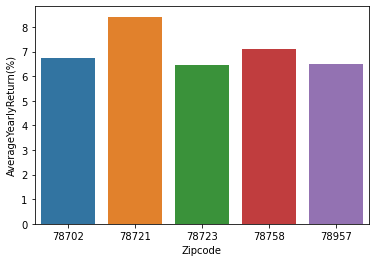

In [19]:
# Top 5 Zipcodes prior to modeling
ax = sns.barplot(x="Zipcode", y="AverageYearlyReturn(%)", data=austin_city_return[:5])

In [20]:
# Plotting the five zipcodes from our baseline model to understand geography
fig = px.scatter_mapbox(data_frame = austin_city_return[:5], # df name
                        lat='Latitude', # name of latitude column
                        lon='Longitude', # name of longitude column
                        color='AverageYearlyReturn(%)', # name of column to use for the color
                        zoom=7.5,
                        size='AverageYearlyReturn(%)')

fig.update_layout(mapbox_style="open-street-map")
fig.show()

### 6.2 Modeling Iterations
When determining how to model our data, we tried several options for making the time series data more stationary:
- Differencing
- Subtracting the rolling mean
- Subtracting the weighted rolling mean
- Time series decomposition

However, when we checked the p-values for each of these modeling strategies, we found that using a **log transformation** produced the most effective results. In order to run all 73 zip codes through the same modeling process, we wrote a function “run_arima_model” (based on a similar function from our friends at Centaur Group). Here is a description of what this function does: 
- Takes the log transformation of a series (the median sale prices for each zip code in our case)
- Runs the logged series through an auto ARIMA grid search in order to determine the best set of parameters for each series.
- Generates predictions and forecasts for each zip code (for one year into the future, given our business understanding).
- Performs an exponentiation of the logged predictions and forecasts in order to return the values back to the original scale.
- Returns data frames for the original series, the predictions, and the forecasts for each zip code.

This function allows us to find the best predictions and forecasts for each ATX zip code. However, we also wrote a “report_metrics” function to give us a way of determining the amount of error in each model. For each zip code, this function calculates:
- Explained Variance
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- R-squared

We also calculated the confidence intervals for each of the forecasts. All of these metrics allow us to compare all 73 of these models to determine which zip codes are generating more reliable predictions.

#### Forecasting 78613 Zip Code: 

In [21]:
# Representative zipcode:
df_final[78613]

time
2009-01-01    205300.0
2009-02-01    205000.0
2009-03-01    204700.0
2009-04-01    204600.0
2009-05-01    204300.0
                ...   
2017-12-01    296200.0
2018-01-01    295900.0
2018-02-01    296400.0
2018-03-01    297500.0
2018-04-01    297300.0
Freq: MS, Name: 78613, Length: 112, dtype: float64

In [22]:
# Get the rolling mean and rolling standard deviation, using a 12-month window
roll_mean = df_final[78613].rolling(window=12, center=False).mean()
roll_std = df_final[78613].rolling(window=12, center=False).std()

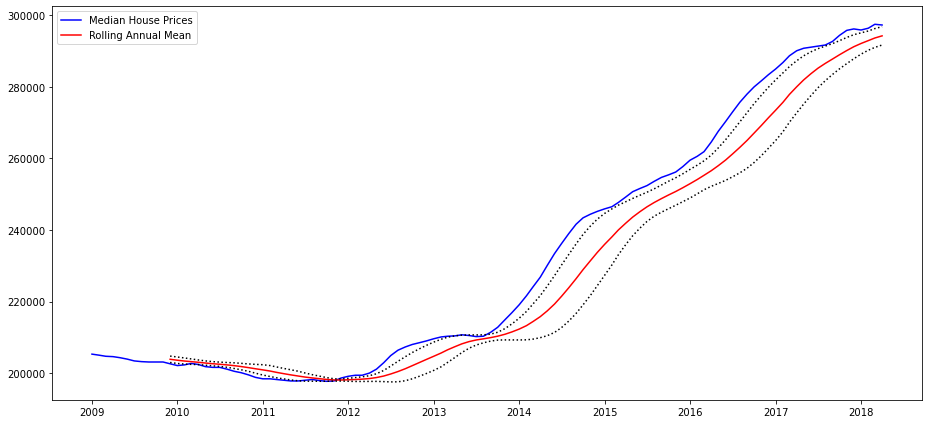

In [23]:
# Visualize the time series with rolling annual mean
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_final[78613], color='blue',
        label='Median House Prices')

ax.plot(roll_mean, color='red', label='Rolling Annual Mean')

ax.plot(roll_mean + roll_std, color='black', linestyle='dotted')
ax.plot(roll_mean - roll_std, color='black', linestyle='dotted')

ax.legend()
fig.tight_layout()

- Data is not stationary, it has upward trend.

In [24]:
# Stationarity test:
adfuller(df_final[78613])

(-0.23428318921425534,
 0.9343098582167808,
 7,
 104,
 {'1%': -3.4948504603223145,
  '5%': -2.889758398668639,
  '10%': -2.5818220155325444},
 1447.0150004986867)

p-value= 0.93, original data is not stationary.

In [25]:
# Take the log transform:
adfuller(np.log(df_final[78613]))

(-0.16997050832547045,
 0.9420076733076995,
 7,
 104,
 {'1%': -3.4948504603223145,
  '5%': -2.889758398668639,
  '10%': -2.5818220155325444},
 -979.8612379667757)

p-value= 0.94, log transformed data is not stationary.

In [26]:
# Take difference to make data stationary:
diff_df = df_final[78613].diff(periods=2).dropna()
adfuller(diff_df)

(-2.3227539918323172,
 0.16473433101872675,
 5,
 104,
 {'1%': -3.4948504603223145,
  '5%': -2.889758398668639,
  '10%': -2.5818220155325444},
 1423.2476463021642)

p-value= 0.16, taking 2 period difference of the data helped a little, but it still not stationary.

In [27]:
# Subtact rolling average:
df_minus_roll_mean = df_final[78613] - roll_mean
df_minus_roll_mean.dropna(inplace=True)
adfuller(df_minus_roll_mean)

(-1.7717411965046919,
 0.39457888198107693,
 7,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1277.2041126454785)

p-value= 0.39, data is not stationary.

In [28]:
# Calculate weighted rolling mean:
exp_roll_mean = df_final[78613].ewm(halflife=2).mean()
adfuller(df_final[78613] - exp_roll_mean)

(-2.2874780962408887,
 0.17603834412304925,
 6,
 105,
 {'1%': -3.4942202045135513,
  '5%': -2.889485291005291,
  '10%': -2.5816762131519275},
 1378.9344430755878)

p-value= 0.17, data is not stationary.

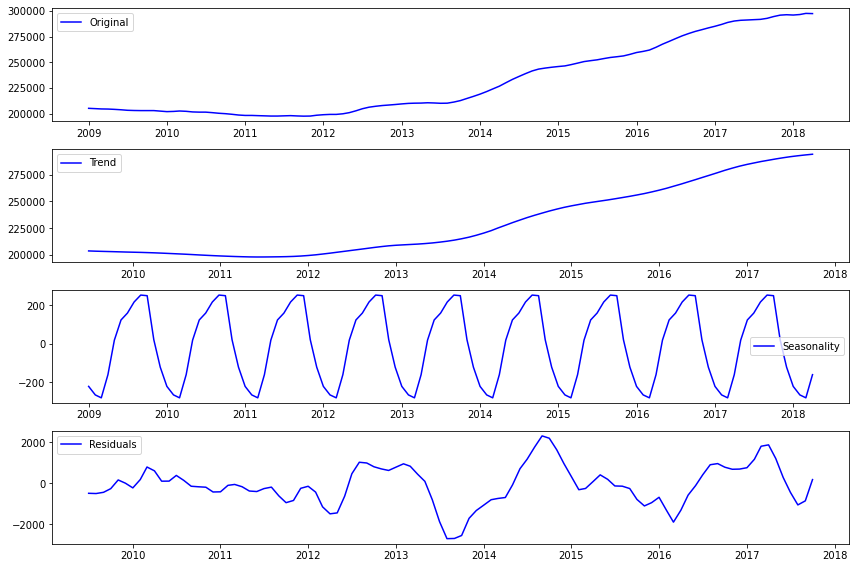

In [29]:
# Look into time series decomposition:
decomposition = seasonal_decompose(df_final[78613], model='additive')

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df_final[78613], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

- We have upward trend, and 12 month period seasonality in the time series.

##### Run Grid Search ARIMA model with Train-Test Split: 

In order to avoid overfitting our models, we also did a train-test split before running our data through these functions. We created a cutoff date of April, 2016 for this split so that our model could train on 7 years worth of data and then be tested on the last 2 before making predictions 1 year into the future. Thus, you will see the plots for all 73 ATX zip codes that include the original time series, our predictions, and the forecasts along with the confidence intervals for each. Below each model you will find the four report metrics as defined in our function above. 

In [30]:
# Train-test split
cutoff = '2016-04-01'

# Define train and test sets according to the cutoff defined above
train = df_final[78613][:cutoff]
test = df_final[78613][cutoff:]

In [31]:
# The code in this cell is written collaboratively with the other group working on this project.
# Define function for grid search ARIMA with hyperparameters:
def run_auto_arima(series):
    
    #(p, d, q) order will be chosen with the grid serch for each time series:
    gridsearch = pm.auto_arima(series,
                            start_p = 0,
                            max_p = 3,
                            d = 0, 
                            max_d = 3, 
                            start_q = 0,
                            max_q = 3,
                            seasonal=True,
                            m = 12,  # we have 12 month of seasonality
                            suppress_warnings=True, error_action='ignore')
    
    model = ARIMA(series, 
                  order = gridsearch.order, 
                  seasonal_order = gridsearch.seasonal_order,
                  enforce_stationarity=False)

    
    return model.fit()

# Define function for in-sample prediction and out-sample forecasting:
def run_arima_model(series, start, end):
    
    logged_series = np.log(series)
    
    model = run_auto_arima(logged_series)
    
    log_prediction = model.predict(start, end)  
    
    log_forecast = model.get_forecast(36)  # want to forecast 36 more months after the cutoff
    
    prediction = np.e ** log_prediction
    
    forecast = np.e** log_forecast.summary_frame()
    
    prediction_df = pd.DataFrame(prediction.values, prediction.index)
    
    return series, prediction_df, forecast

We have 112 months in our series for each zipcode.
We want to forecast 12 more months into the future.

In [32]:
# Run grid search ARIMA for zipcode 78613
original_series, prediction_series, forecast = run_arima_model(train, 0, 123)

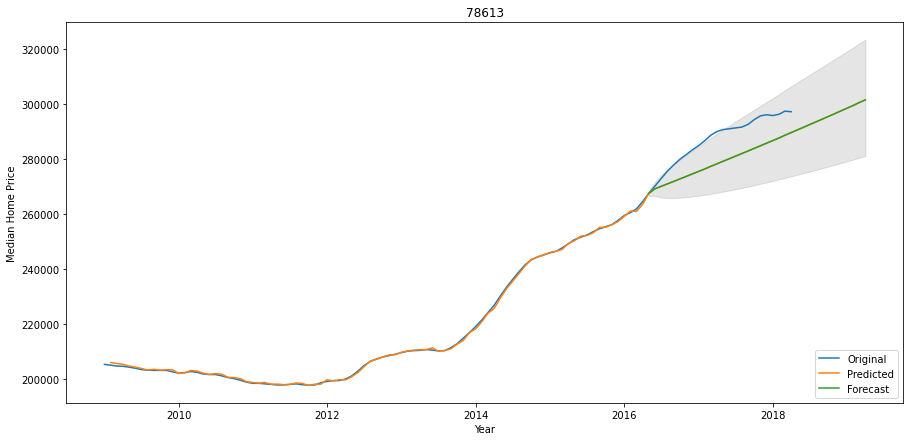

In [33]:
# Plot predictions, forecast and original data together:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(df_final[78613])
plt.plot(prediction_series[1:])
plt.plot(forecast['mean'])
ax.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='k', alpha=0.1);
plt.title('78613')
plt.legend(['Original','Predicted', 'Forecast'], loc='lower right')
plt.xlabel('Year')
plt.ylabel('Median Home Price')
plt.show()

In [34]:
# These metrics are used to evaluate model performance:
# Function is from Time Series review notebook
def report_metrics(y_true, y_pred):
    print("Explained Variance:\n\t", metrics.explained_variance_score(y_true, y_pred))
    print("MAE:\n\t", metrics.mean_absolute_error(y_true, y_pred))
    print("RMSE:\n\t", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r^2:\n\t", metrics.r2_score(y_true, y_pred))
    
report_metrics(df_final[78613][1:], prediction_series[1:-12])

Explained Variance:
	 0.9882972697848397
MAE:
	 2067.2425737415183
RMSE:
	 4148.6202306739615
r^2:
	 0.9856397478761612


- We got 99% explained variance with grid search ARIMA model for 78613 zip code.

#### Forecasting All Zip Codes in Austin Metro Area:

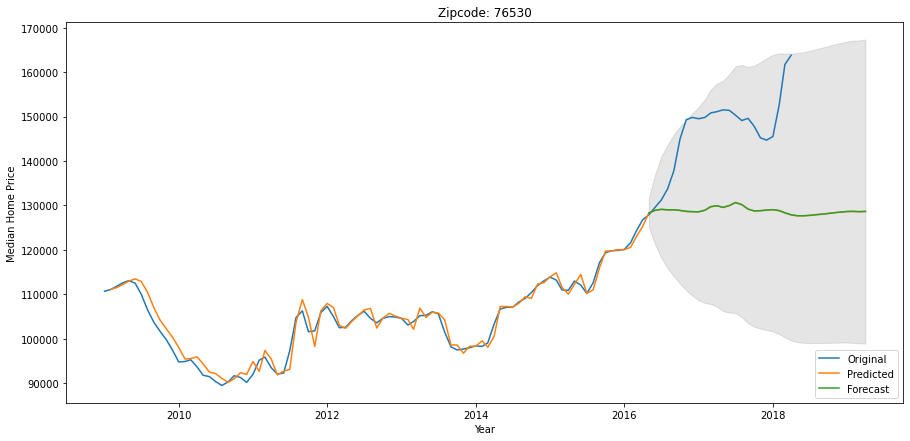

Zipcode: 76530
Explained Variance:
	 0.8052101435284958
MAE:
	 4721.34229671645
RMSE:
	 9221.960529518008
r^2:
	 0.7736581065184631
Expected ROI for 76530: -0.21454189084033634


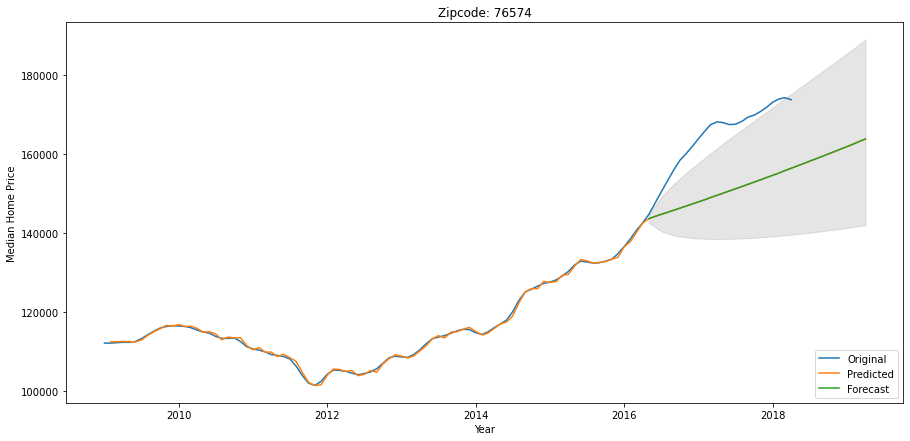

Zipcode: 76574
Explained Variance:
	 0.9150859461207981
MAE:
	 3393.921504811885
RMSE:
	 7139.3966371061715
r^2:
	 0.894890564755279
Expected ROI for 76574: -0.05718842392433919


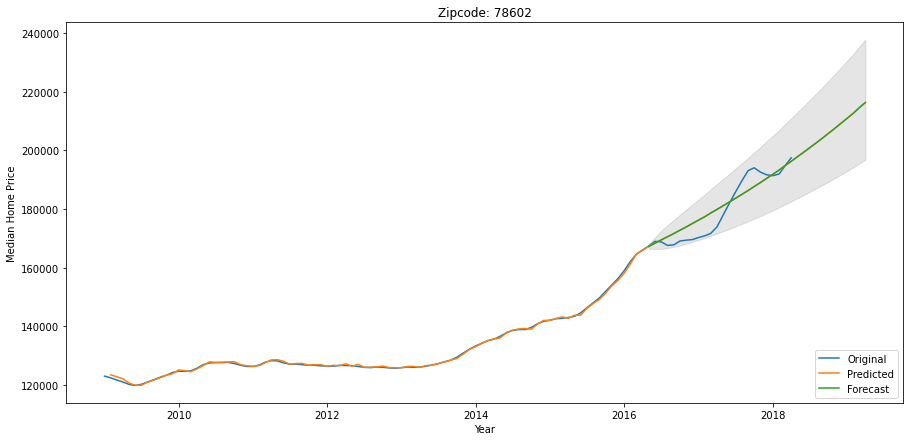

Zipcode: 78602
Explained Variance:
	 0.9928713638651823
MAE:
	 939.4985344057482
RMSE:
	 1908.6207183284662
r^2:
	 0.9927366234947391
Expected ROI for 78602: 0.09558675977577827


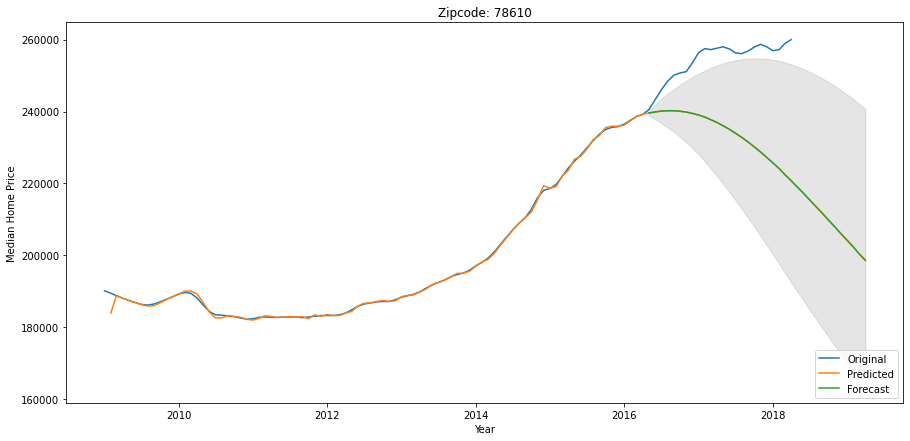

Zipcode: 78610
Explained Variance:
	 0.8856604003394347
MAE:
	 4607.968573543174
RMSE:
	 10549.058916934464
r^2:
	 0.8612014749357254
Expected ROI for 78610: -0.23606192913312787


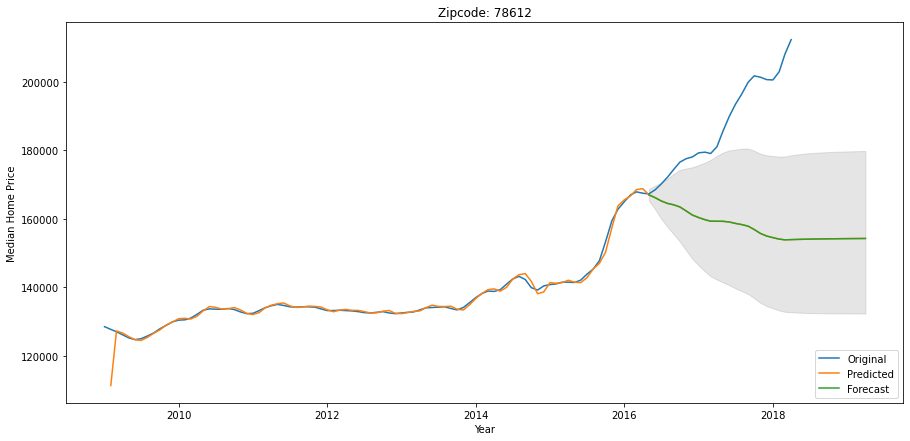

Zipcode: 78612
Explained Variance:
	 0.6359136864714385
MAE:
	 6523.493404784112
RMSE:
	 15295.495792863541
r^2:
	 0.5660977286851826
Expected ROI for 78612: -0.2736893378776211


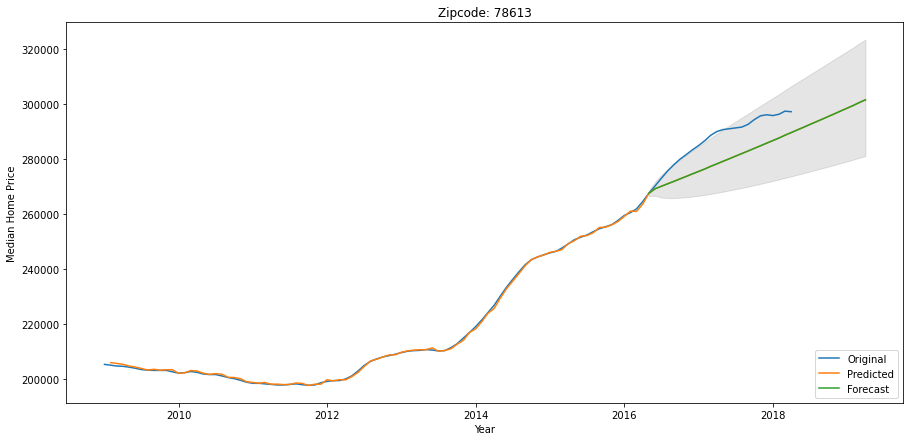

Zipcode: 78613
Explained Variance:
	 0.9882972697848397
MAE:
	 2067.2425737415183
RMSE:
	 4148.6202306739615
r^2:
	 0.9856397478761612
Expected ROI for 78613: 0.014548153908192746


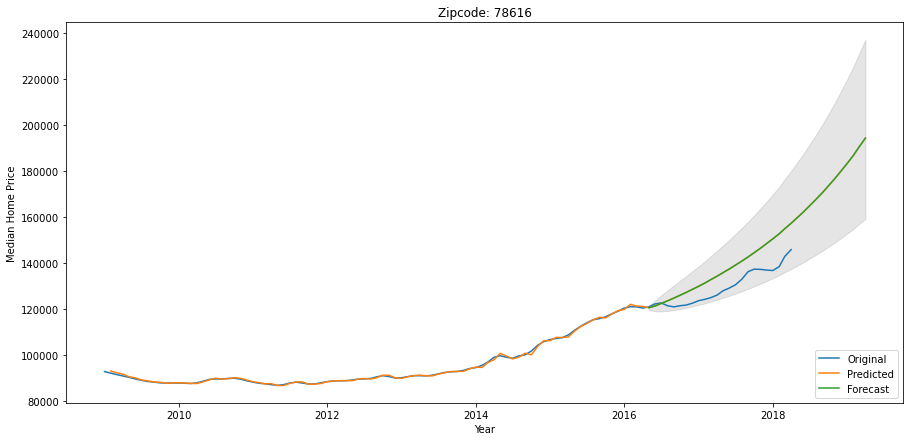

Zipcode: 78616
Explained Variance:
	 0.9584201681182234
MAE:
	 1795.0184454441462
RMSE:
	 3781.302681952882
r^2:
	 0.9502359714004258
Expected ROI for 78616: 0.33223212716579903


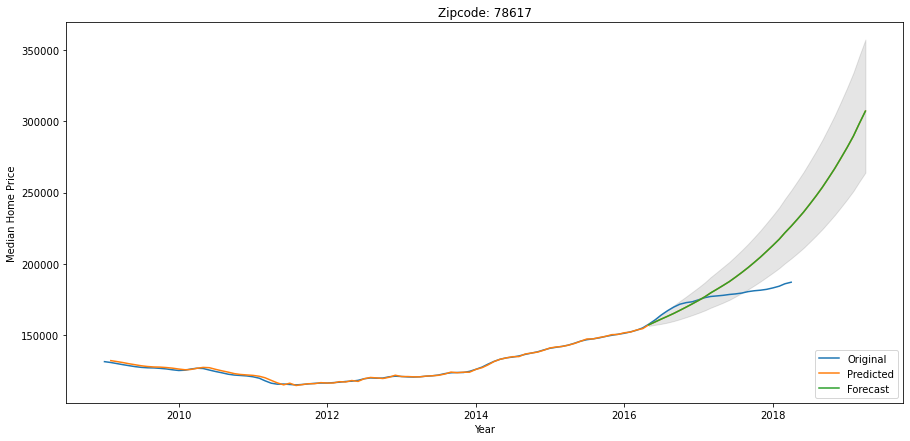

Zipcode: 78617
Explained Variance:
	 0.8784516749162834
MAE:
	 3084.8074138225547
RMSE:
	 8133.415634691408
r^2:
	 0.8653898894651315
Expected ROI for 78617: 0.6412202679737027


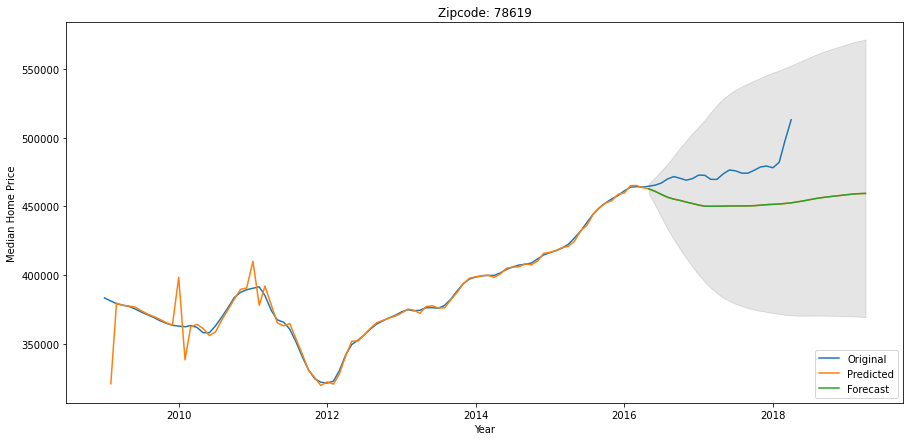

Zipcode: 78619
Explained Variance:
	 0.9268186894760558
MAE:
	 7165.738053862763
RMSE:
	 14046.977629913114
r^2:
	 0.914782676019132
Expected ROI for 78619: -0.1042929048535385


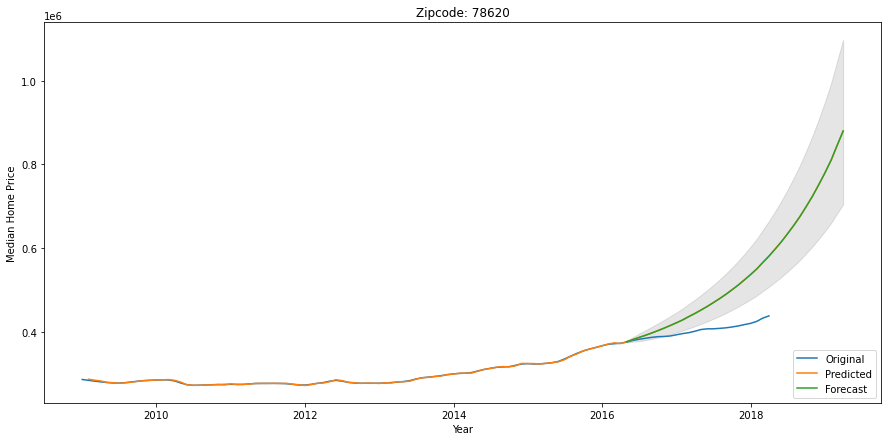

Zipcode: 78620
Explained Variance:
	 0.6278042337961747
MAE:
	 12651.99048637792
RMSE:
	 33242.86142558963
r^2:
	 0.5699973857033429
Expected ROI for 78620: 1.00543416986363


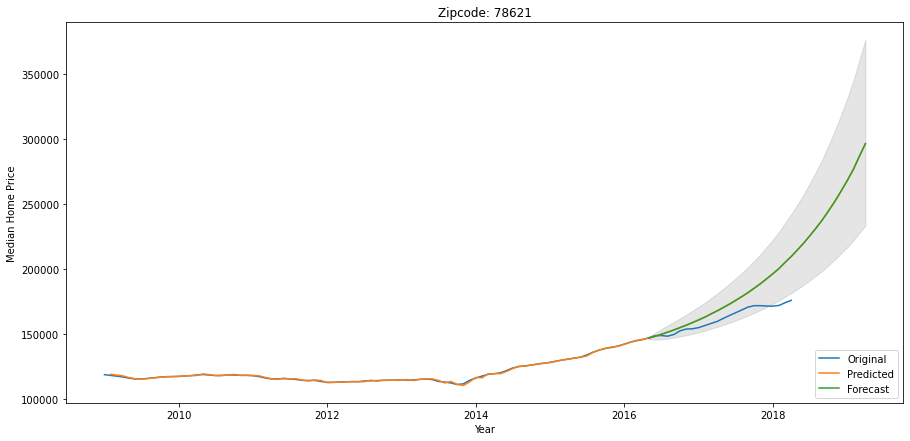

Zipcode: 78621
Explained Variance:
	 0.8874781506903482
MAE:
	 2621.7067530998584
RMSE:
	 6825.069514686504
r^2:
	 0.8719618674784632
Expected ROI for 78621: 0.685108731786734


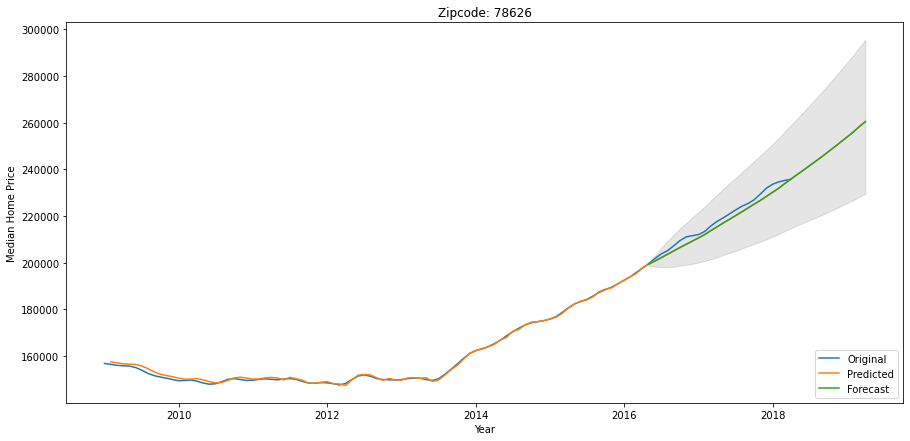

Zipcode: 78626
Explained Variance:
	 0.9982784729589392
MAE:
	 818.356271434209
RMSE:
	 1177.8426358184581
r^2:
	 0.9982123355089848
Expected ROI for 78626: 0.10464860978182014


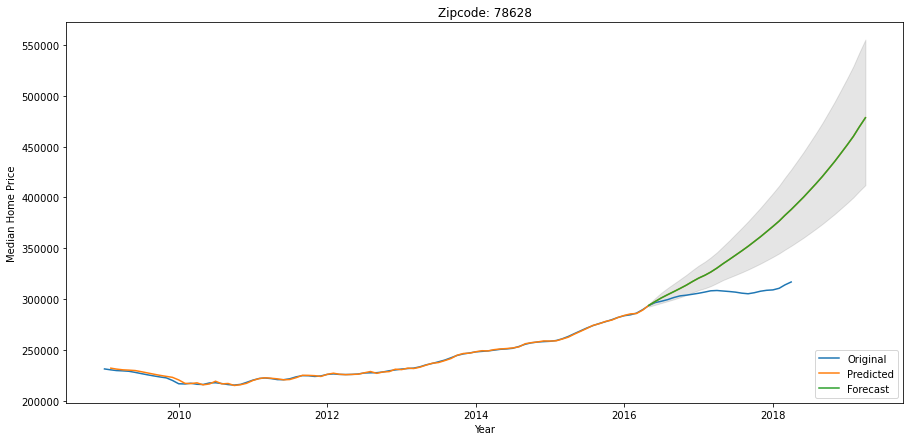

Zipcode: 78628
Explained Variance:
	 0.7509149470212113
MAE:
	 7081.852121845177
RMSE:
	 17883.974072871246
r^2:
	 0.709076268469969
Expected ROI for 78628: 0.5102805609249369


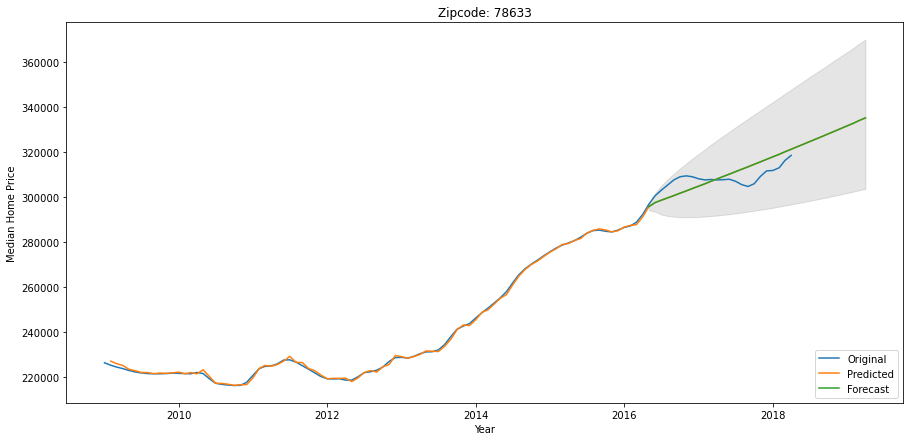

Zipcode: 78633
Explained Variance:
	 0.9951849072088487
MAE:
	 1389.9541518020405
RMSE:
	 2467.2050732436173
r^2:
	 0.9951609457162637
Expected ROI for 78633: 0.052290975600196576


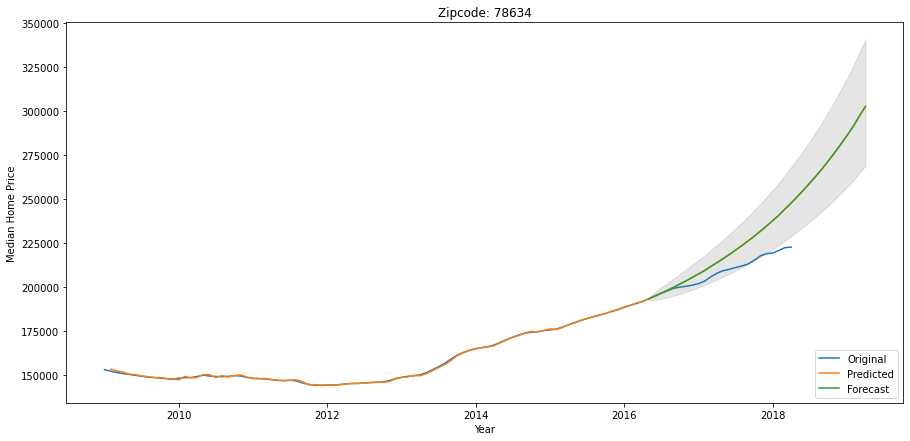

Zipcode: 78634
Explained Variance:
	 0.9586700724603664
MAE:
	 2143.305206282458
RMSE:
	 5356.294072687597
r^2:
	 0.9524841344238828
Expected ROI for 78634: 0.3591164835346261


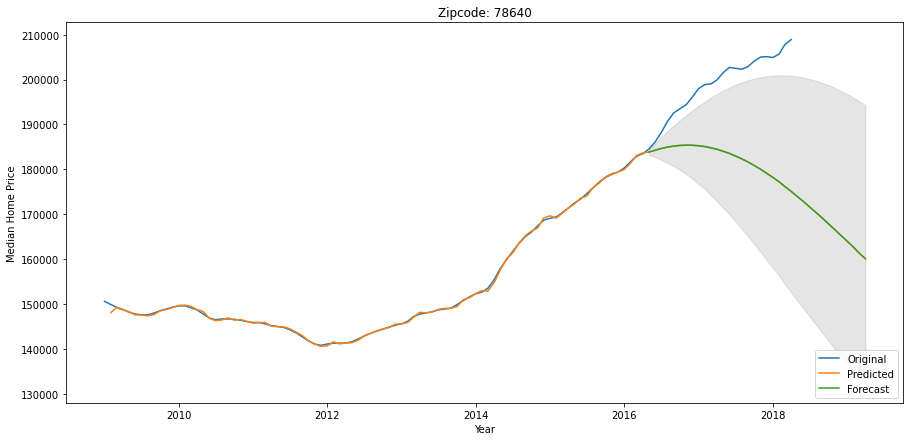

Zipcode: 78640
Explained Variance:
	 0.8646392995561081
MAE:
	 3728.9962498730138
RMSE:
	 8791.398599889499
r^2:
	 0.8374319713848104
Expected ROI for 78640: -0.23375070494575065


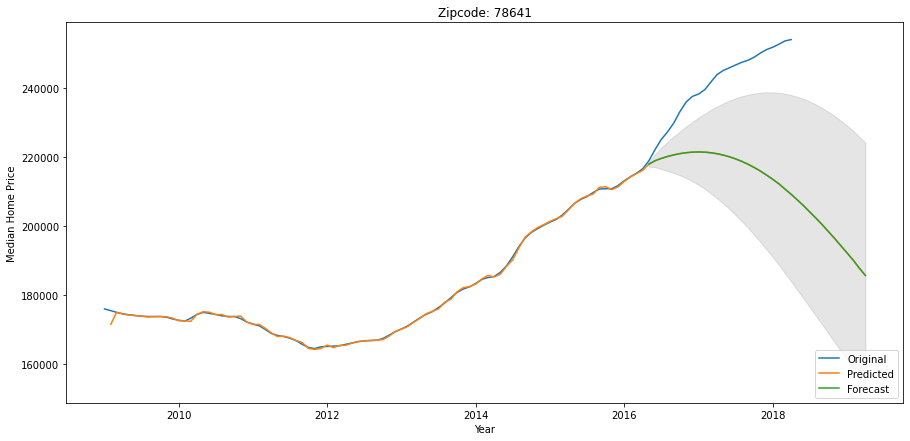

Zipcode: 78641
Explained Variance:
	 0.8488710165989296
MAE:
	 5204.035732459319
RMSE:
	 12251.106756138808
r^2:
	 0.8181147561297915
Expected ROI for 78641: -0.269530030919175


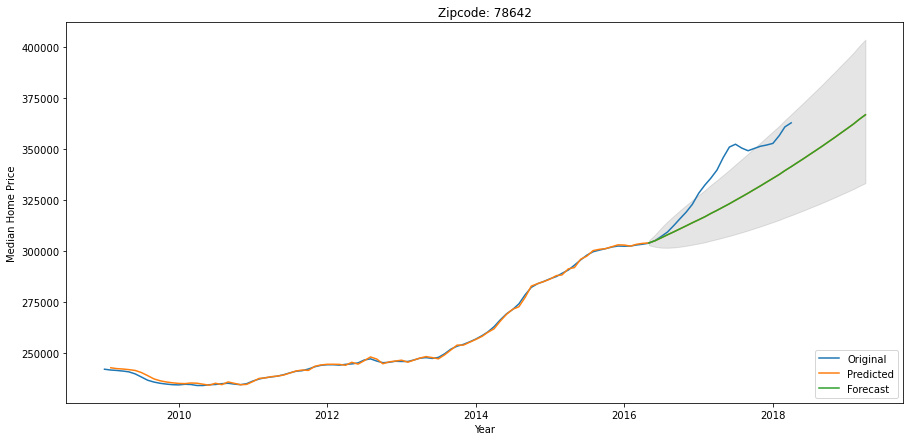

Zipcode: 78642
Explained Variance:
	 0.9653040698069566
MAE:
	 3611.547688743982
RMSE:
	 8018.300787800875
r^2:
	 0.9595641118269838
Expected ROI for 78642: 0.010878031767295286


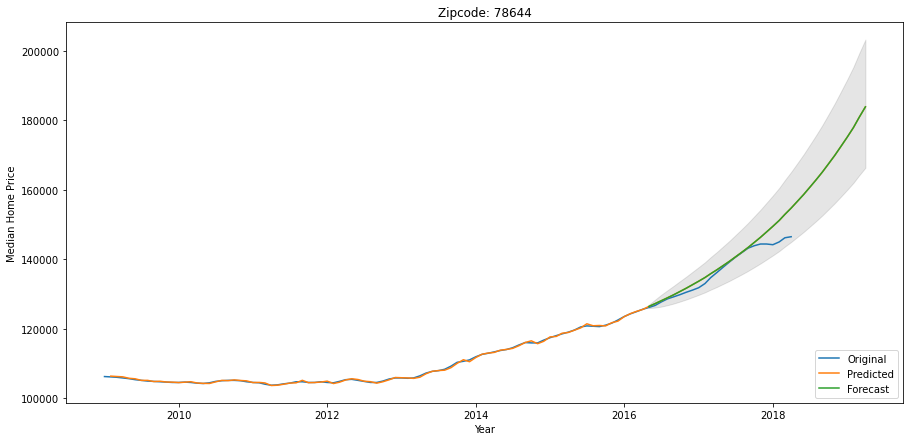

Zipcode: 78644
Explained Variance:
	 0.9895483827610728
MAE:
	 541.3115050534574
RMSE:
	 1391.7416959332234
r^2:
	 0.9885510040290124
Expected ROI for 78644: 0.2554800328368374


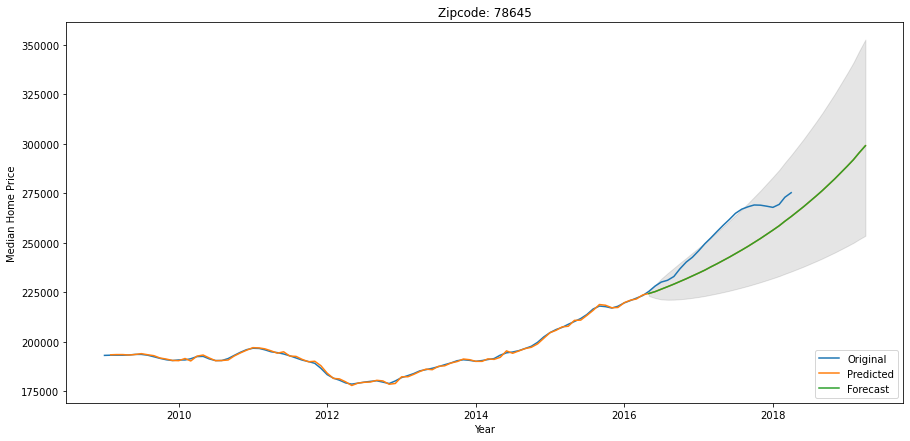

Zipcode: 78645
Explained Variance:
	 0.9562696656716536
MAE:
	 2943.5034429953216
RMSE:
	 6261.576984904758
r^2:
	 0.947223658436616
Expected ROI for 78645: 0.08609666134239355


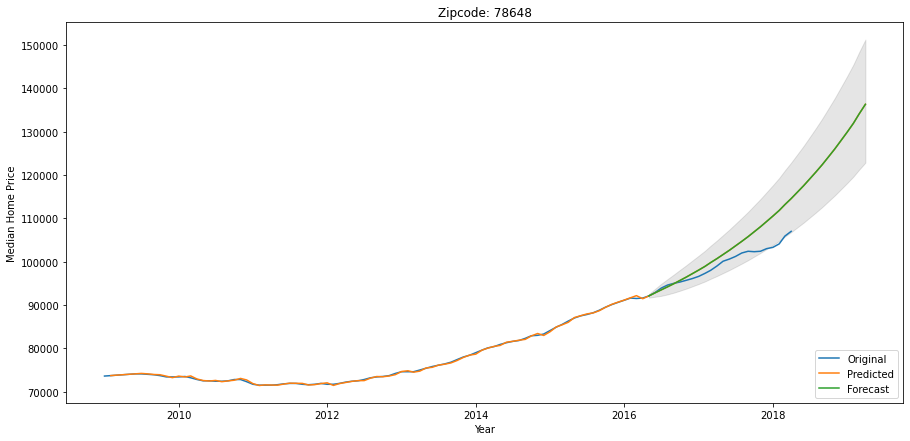

Zipcode: 78648
Explained Variance:
	 0.974933885572519
MAE:
	 713.293219614017
RMSE:
	 1802.616037221697
r^2:
	 0.9718583966654797
Expected ROI for 78648: 0.27401458322920913


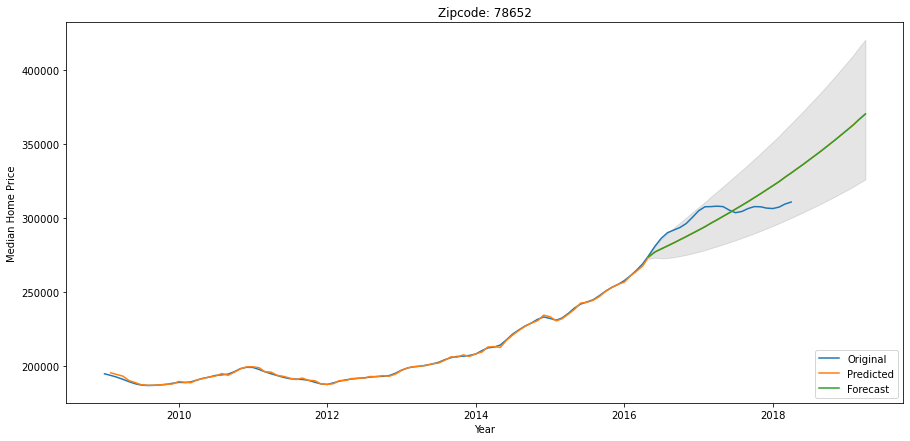

Zipcode: 78652
Explained Variance:
	 0.9872113068534275
MAE:
	 2393.5191310008
RMSE:
	 4923.029587983441
r^2:
	 0.9872112772523723
Expected ROI for 78652: 0.19134443426517297


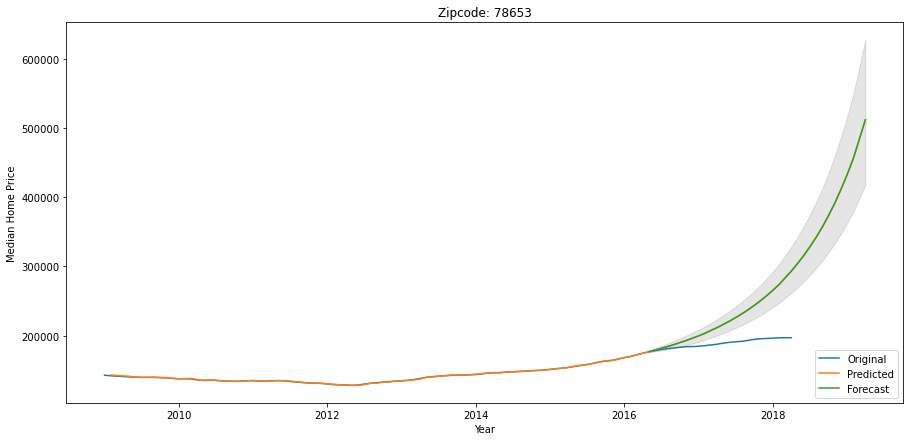

Zipcode: 78653
Explained Variance:
	 0.24022260850736588
MAE:
	 7322.5084042830085
RMSE:
	 20140.516963591235
r^2:
	 0.13135561181026623
Expected ROI for 78653: 1.6021937580590409


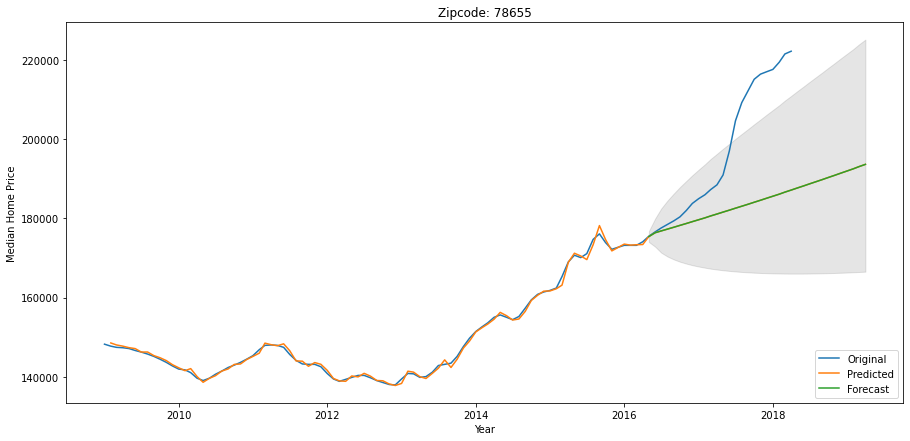

Zipcode: 78655
Explained Variance:
	 0.8504725882351098
MAE:
	 3713.325320551731
RMSE:
	 9564.040037828328
r^2:
	 0.8298676265250926
Expected ROI for 78655: -0.12875307539363218


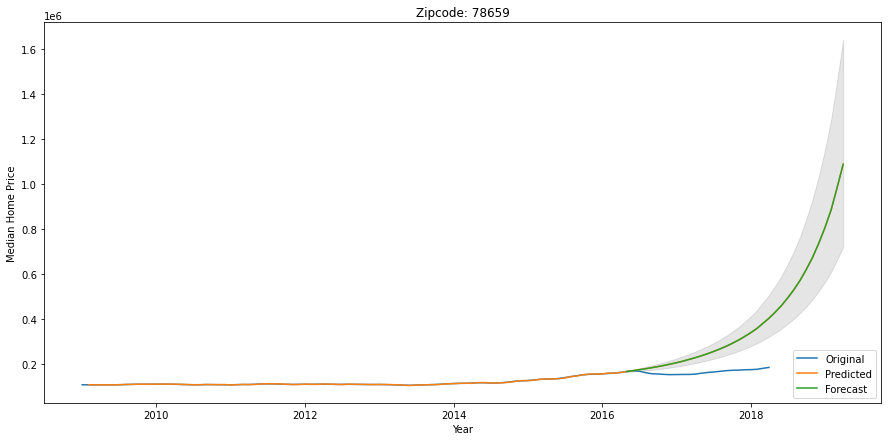

Zipcode: 78659
Explained Variance:
	 -2.518180511904162
MAE:
	 18726.499237423486
RMSE:
	 48834.6953714074
r^2:
	 -3.098701300242306
Expected ROI for 78659: 4.86196800924966


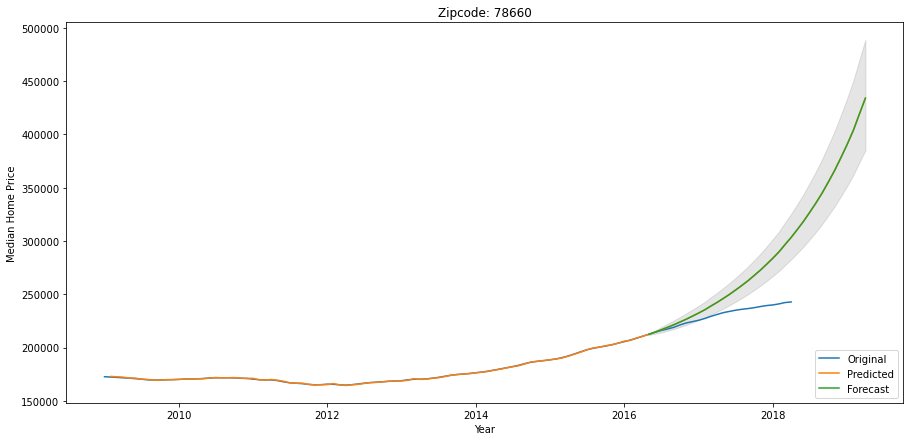

Zipcode: 78660
Explained Variance:
	 0.7797279953673667
MAE:
	 4297.8747207868255
RMSE:
	 12337.945129106953
r^2:
	 0.7516026640568101
Expected ROI for 78660: 0.7877610387782281


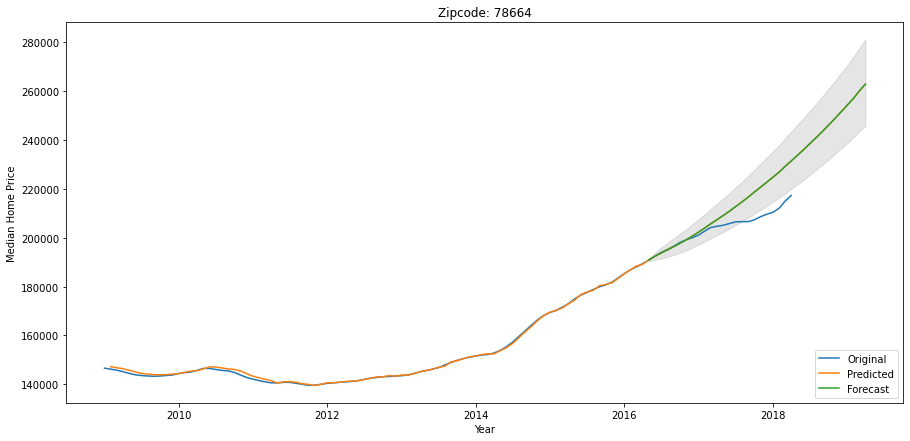

Zipcode: 78664
Explained Variance:
	 0.9804725483606456
MAE:
	 1533.3647810837297
RMSE:
	 3744.765836469645
r^2:
	 0.9773619998857637
Expected ROI for 78664: 0.21002871906224266


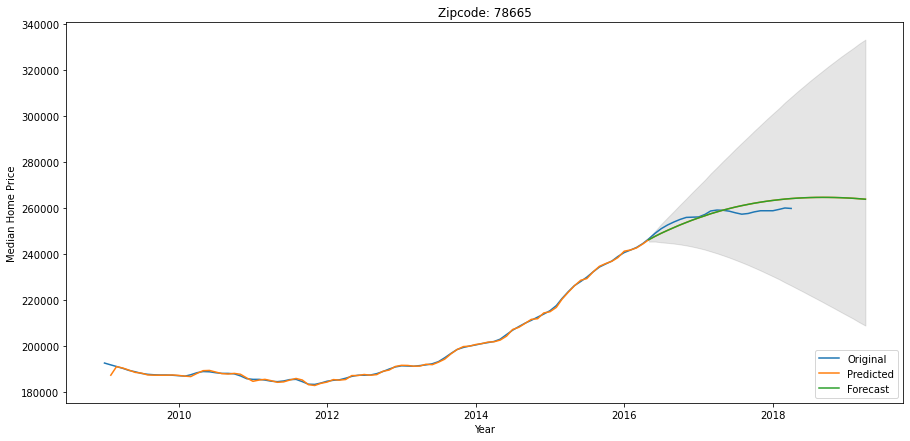

Zipcode: 78665
Explained Variance:
	 0.9975879141956748
MAE:
	 784.9732401243839
RMSE:
	 1399.0918638652597
r^2:
	 0.9975690212670999
Expected ROI for 78665: 0.015470122758680026


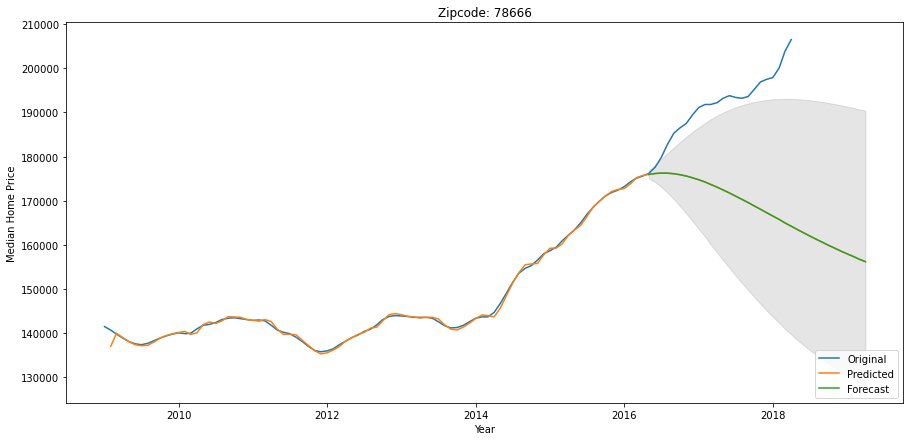

Zipcode: 78666
Explained Variance:
	 0.7927427434900113
MAE:
	 4528.795816216606
RMSE:
	 10525.342215311239
r^2:
	 0.7505490398291115
Expected ROI for 78666: -0.2435426363446854


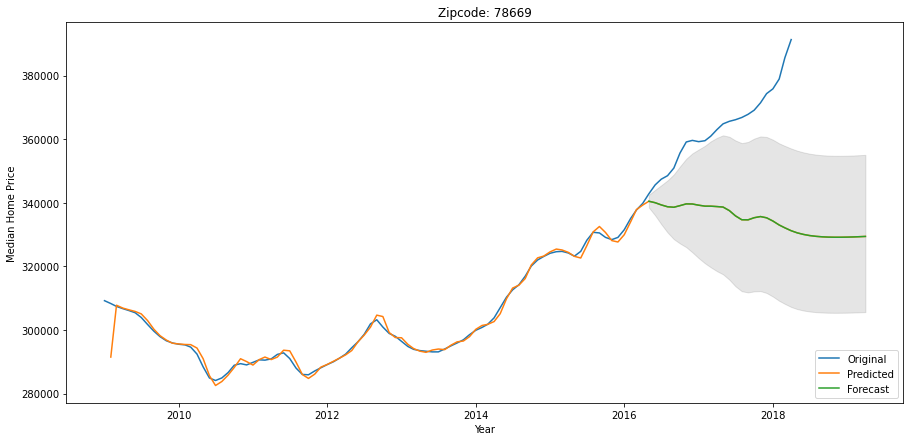

Zipcode: 78669
Explained Variance:
	 0.7968328464374536
MAE:
	 6492.231102314539
RMSE:
	 14217.521267794318
r^2:
	 0.7559811641235559
Expected ROI for 78669: -0.15818658971166405


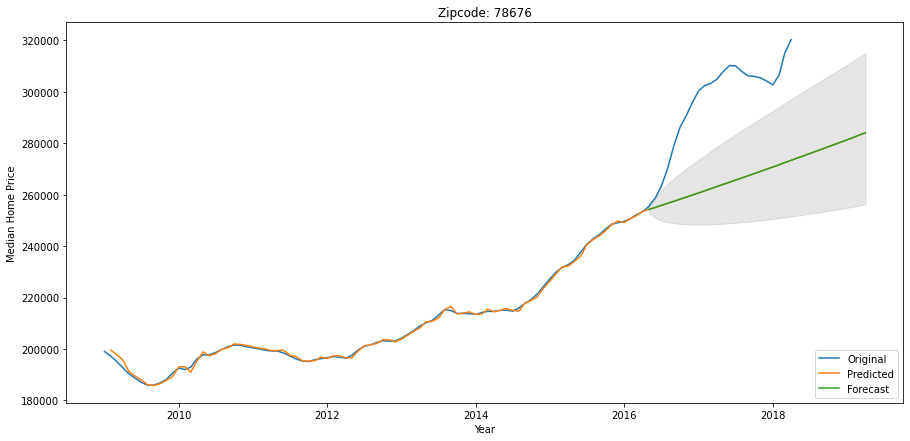

Zipcode: 78676
Explained Variance:
	 0.8622219902044004
MAE:
	 7528.261720998568
RMSE:
	 16413.460959915436
r^2:
	 0.8312363008892979
Expected ROI for 78676: -0.11315083209133354


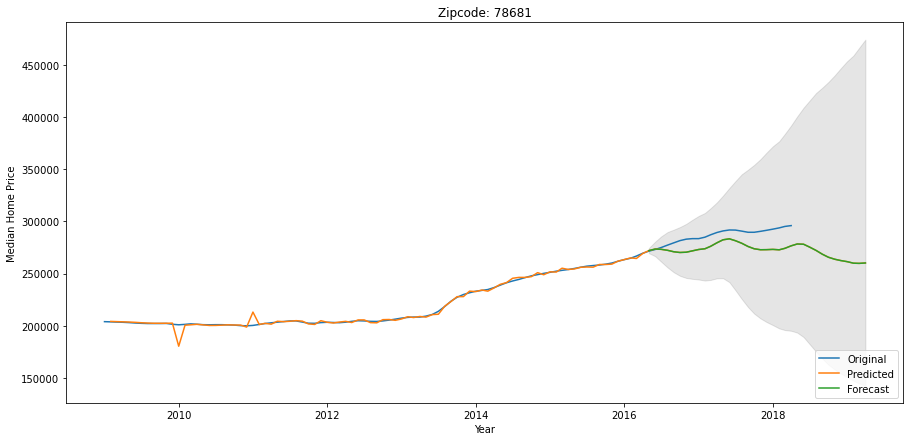

Zipcode: 78681
Explained Variance:
	 0.9690708306867576
MAE:
	 3386.195504770543
RMSE:
	 6542.454860942935
r^2:
	 0.9632621256116222
Expected ROI for 78681: -0.12107754237711217


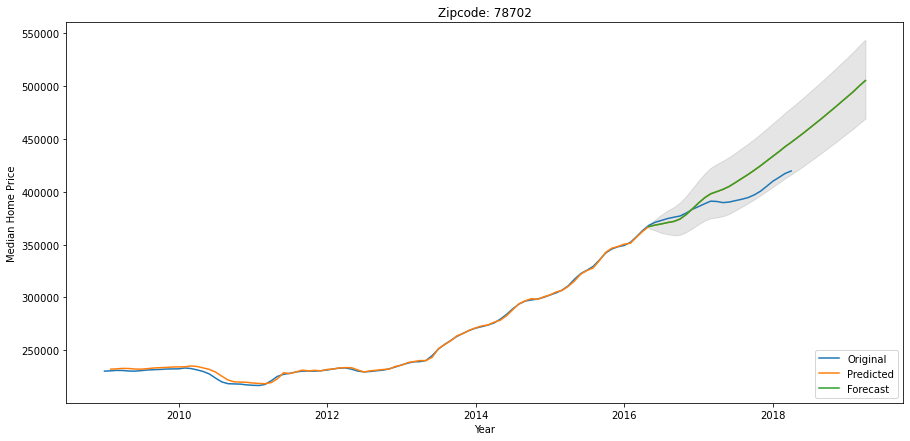

Zipcode: 78702
Explained Variance:
	 0.9891548678855392
MAE:
	 3628.8469338073146
RMSE:
	 7492.833905423685
r^2:
	 0.9871737822844925
Expected ROI for 78702: 0.20400276059035005


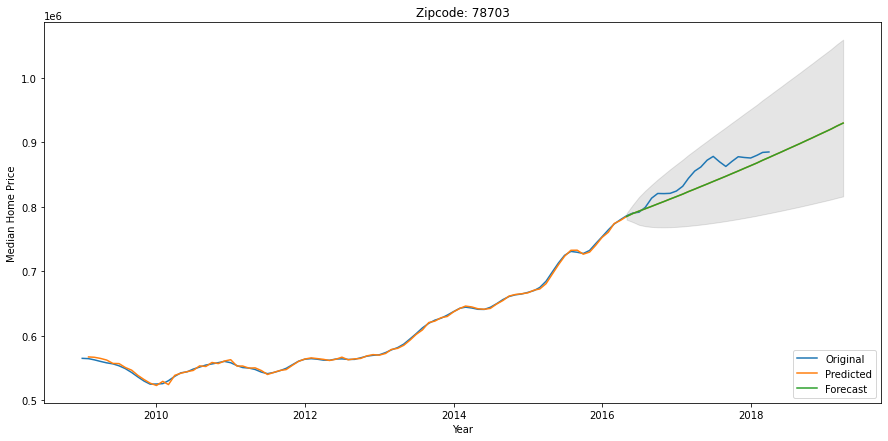

Zipcode: 78703
Explained Variance:
	 0.995032879641205
MAE:
	 4687.29225350581
RMSE:
	 8929.116614786375
r^2:
	 0.9942643585109737
Expected ROI for 78703: 0.05067654839876464


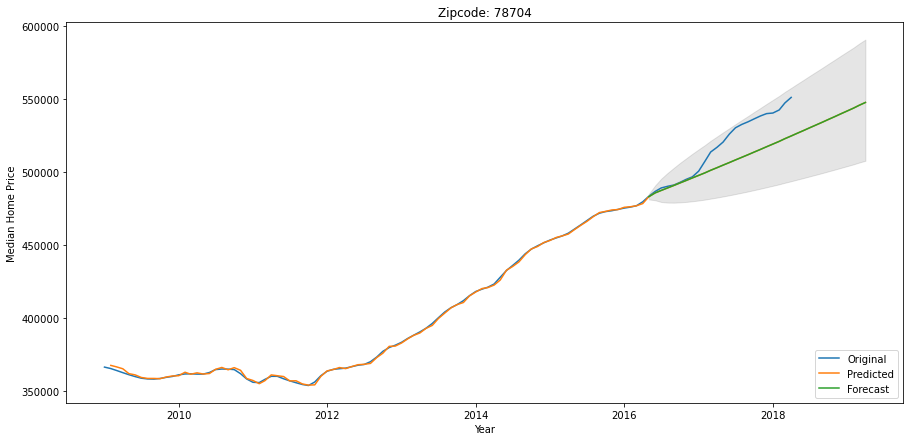

Zipcode: 78704
Explained Variance:
	 0.9873633277391345
MAE:
	 3273.441318878487
RMSE:
	 7588.748295444658
r^2:
	 0.9854718074411289
Expected ROI for 78704: -0.006292737154331499


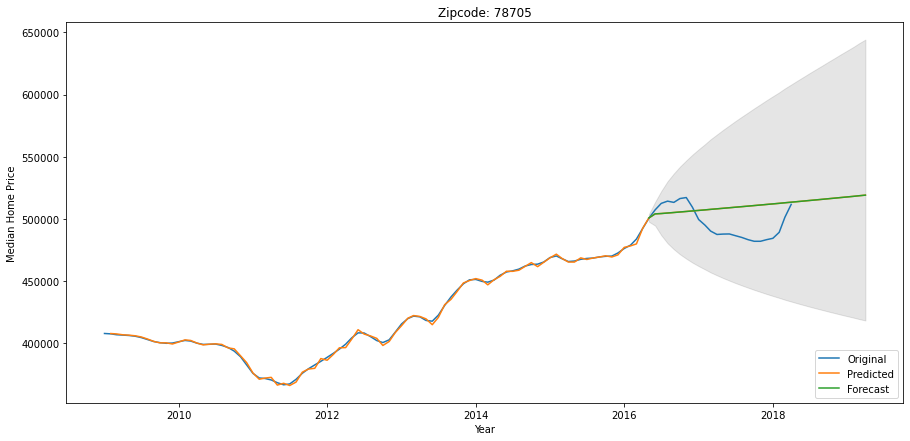

Zipcode: 78705
Explained Variance:
	 0.9643712138886248
MAE:
	 4168.360895120952
RMSE:
	 8614.07259093424
r^2:
	 0.9615985202501877
Expected ROI for 78705: 0.014533815480298742


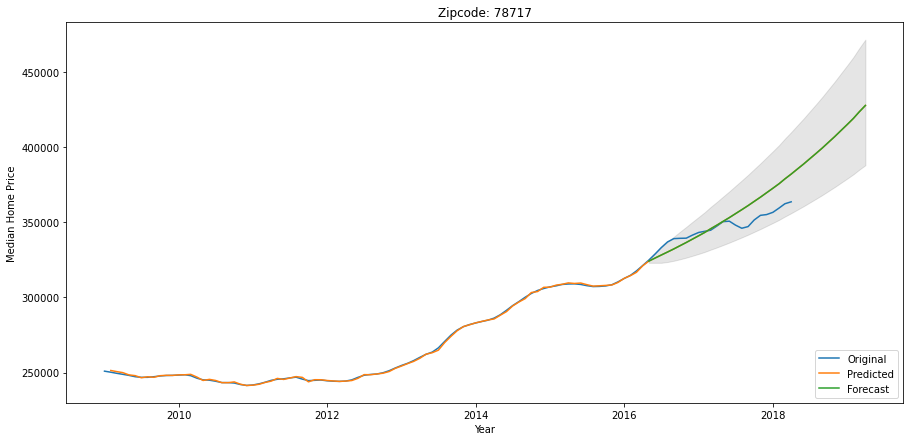

Zipcode: 78717
Explained Variance:
	 0.988115226507929
MAE:
	 1940.4010269296384
RMSE:
	 4499.364824689892
r^2:
	 0.9875114952847595
Expected ROI for 78717: 0.1763535584996436


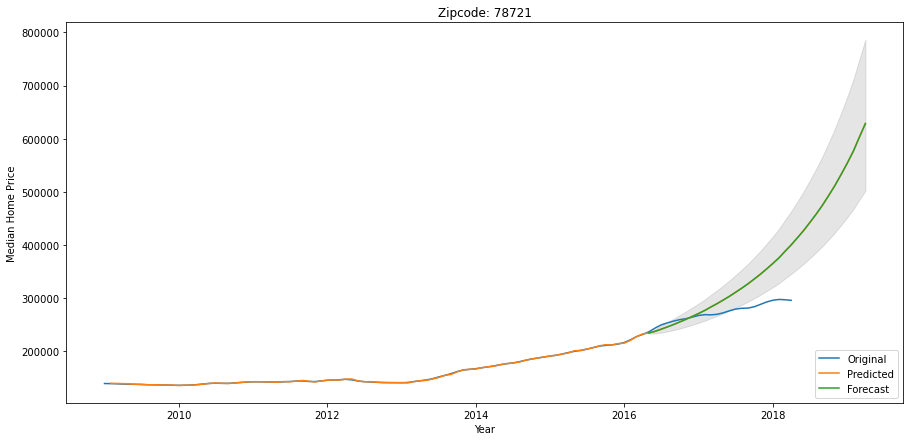

Zipcode: 78721
Explained Variance:
	 0.8630246204578037
MAE:
	 7187.263066255152
RMSE:
	 20499.188659470583
r^2:
	 0.8489786934551974
Expected ROI for 78721: 1.1227292079008213


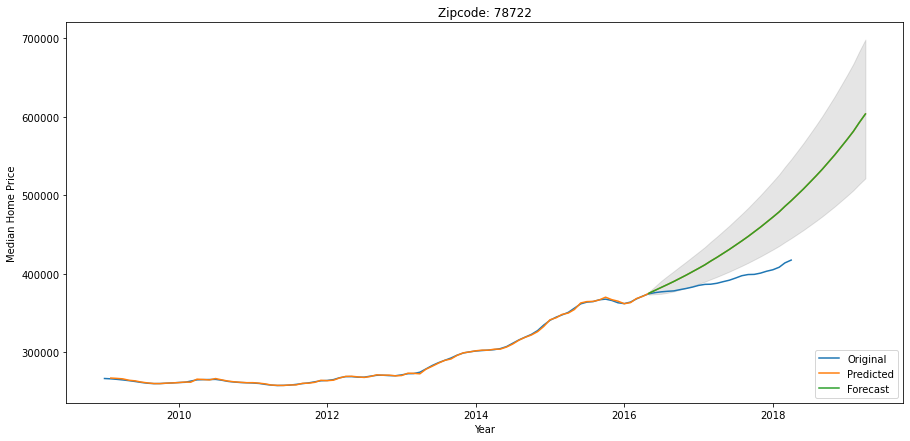

Zipcode: 78722
Explained Variance:
	 0.8824822410564563
MAE:
	 8200.358175683437
RMSE:
	 19840.015066666954
r^2:
	 0.8612013215616257
Expected ROI for 78722: 0.4452933205470624


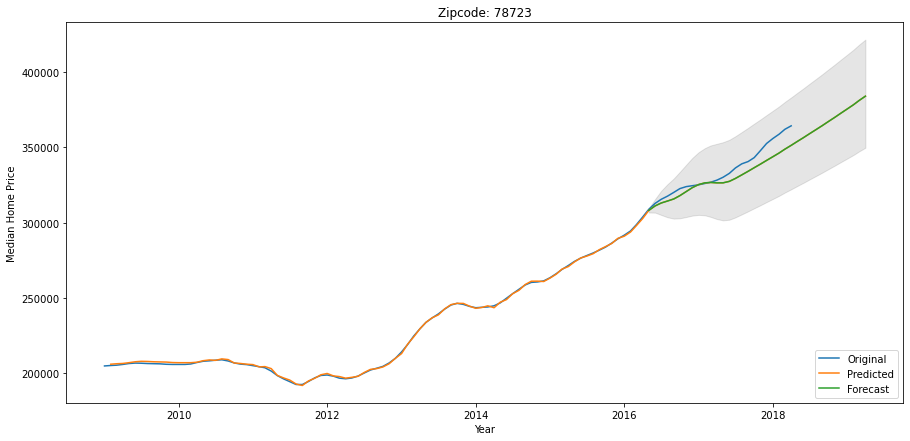

Zipcode: 78723
Explained Variance:
	 0.9964002633746711
MAE:
	 1619.7797807729096
RMSE:
	 3282.939533451432
r^2:
	 0.9960336523935688
Expected ROI for 78723: 0.05398966590241588


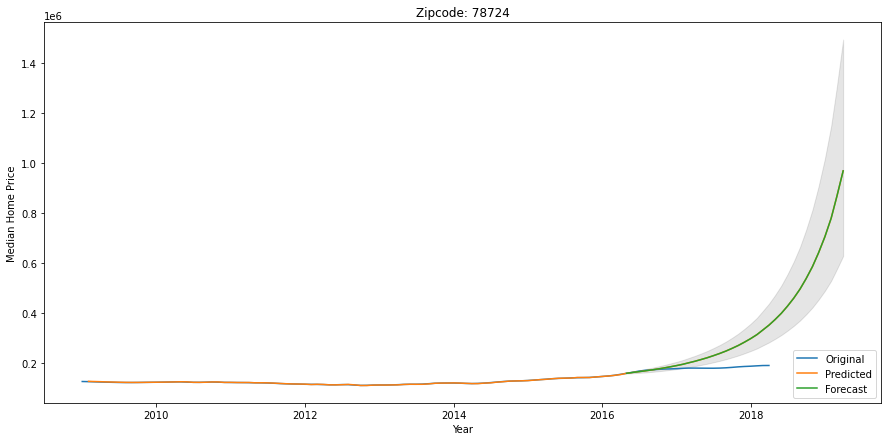

Zipcode: 78724
Explained Variance:
	 -0.49112748454513966
MAE:
	 10624.264164767446
RMSE:
	 31716.720069801675
r^2:
	 -0.6667462554014485
Expected ROI for 78724: 4.120780535779386


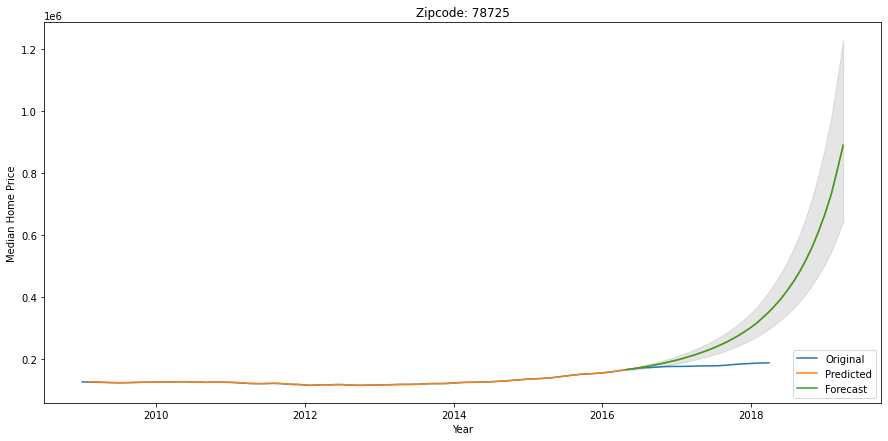

Zipcode: 78725
Explained Variance:
	 -0.8211746067009931
MAE:
	 11772.416614106101
RMSE:
	 33569.531312972635
r^2:
	 -1.0654051975587189
Expected ROI for 78725: 3.7222996885168524


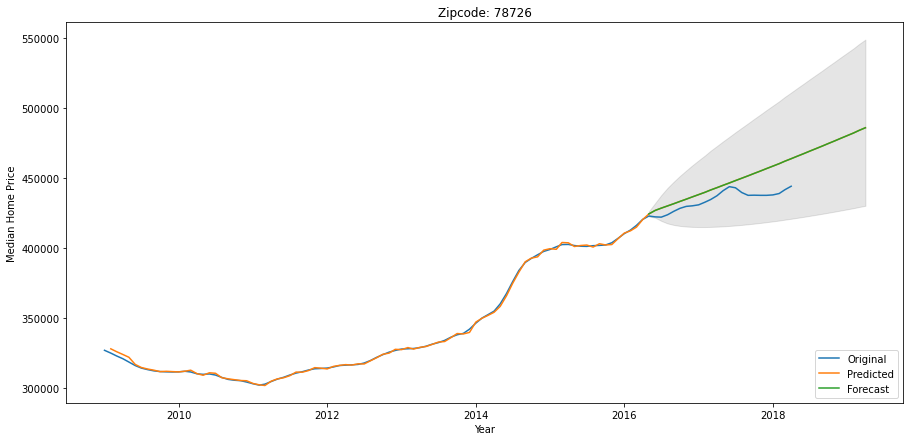

Zipcode: 78726
Explained Variance:
	 0.9899668057269423
MAE:
	 2710.0514673302737
RMSE:
	 5567.1249515647005
r^2:
	 0.9880489226953135
Expected ROI for 78726: 0.09417576317980461


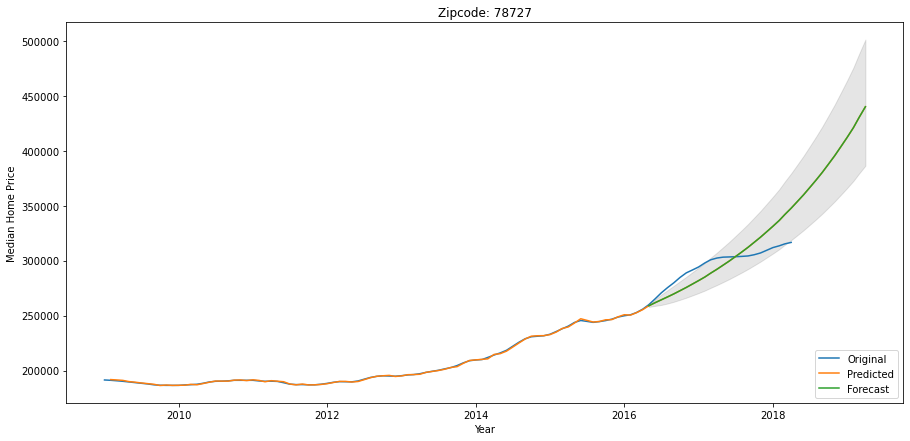

Zipcode: 78727
Explained Variance:
	 0.9770003563401087
MAE:
	 2820.0653921141493
RMSE:
	 6470.822271155257
r^2:
	 0.9769593213163895
Expected ROI for 78727: 0.38991454825466915


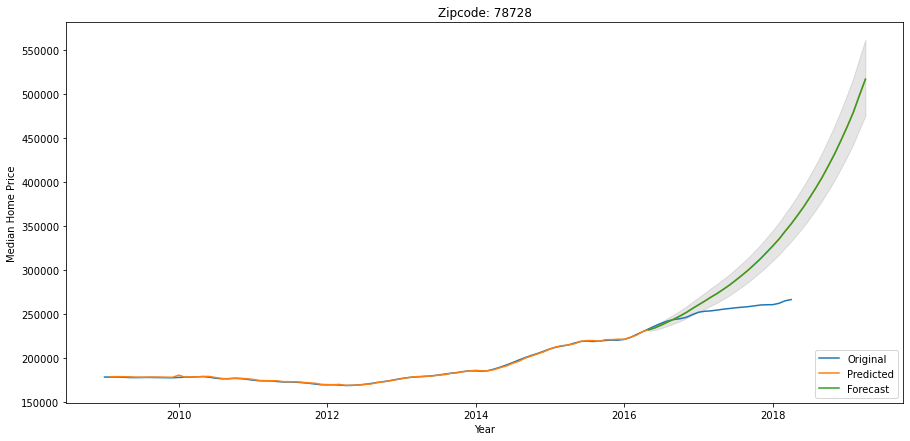

Zipcode: 78728
Explained Variance:
	 0.6977450500744873
MAE:
	 6653.697150872747
RMSE:
	 18535.06766324672
r^2:
	 0.6583114970229633
Expected ROI for 78728: 0.9407459375904502


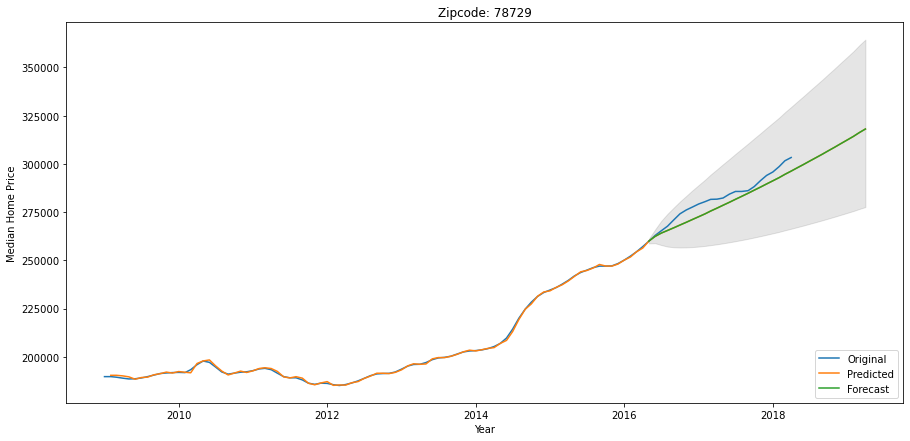

Zipcode: 78729
Explained Variance:
	 0.9970251133333826
MAE:
	 1196.3100287759821
RMSE:
	 2221.8138247240686
r^2:
	 0.9964808534599975
Expected ROI for 78729: 0.04870688188225912


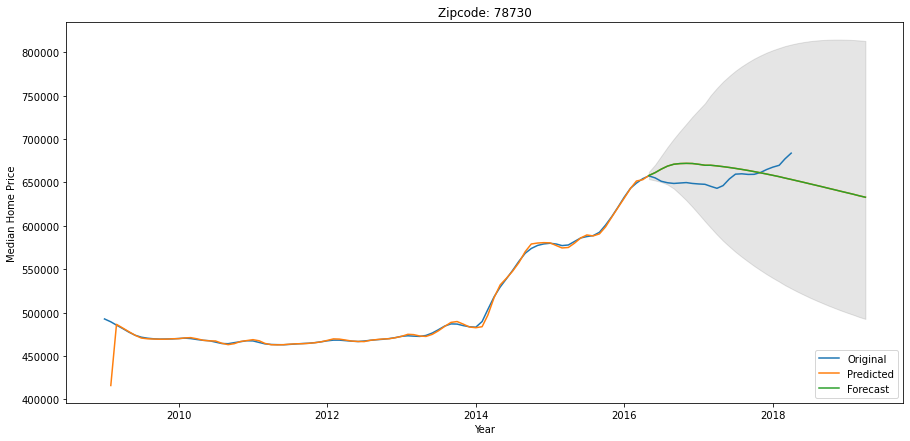

Zipcode: 78730
Explained Variance:
	 0.9818250522390922
MAE:
	 4699.963610402796
RMSE:
	 10781.058575404082
r^2:
	 0.9816272694696945
Expected ROI for 78730: -0.0742783024879327


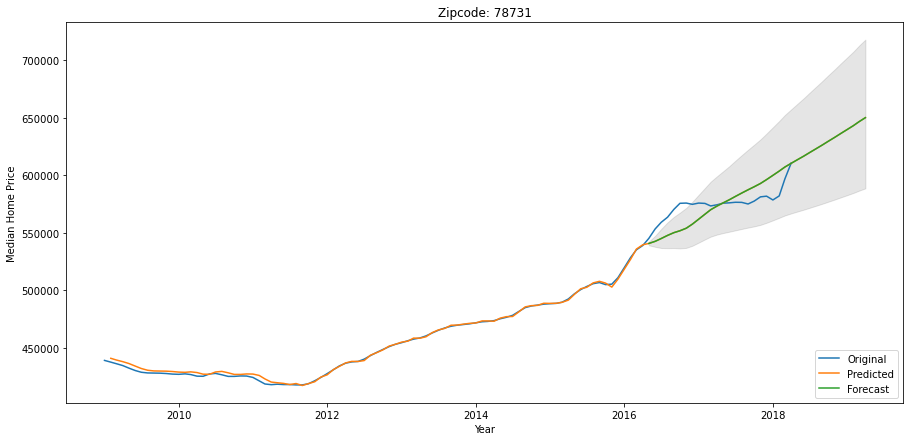

Zipcode: 78731
Explained Variance:
	 0.9872936480864991
MAE:
	 3437.476264687814
RMSE:
	 6475.227490776472
r^2:
	 0.9872668283914158
Expected ROI for 78731: 0.0646472020844588


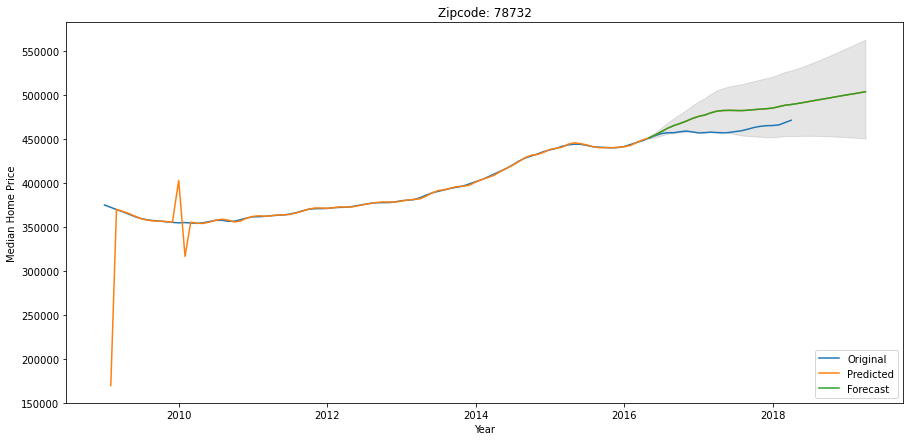

Zipcode: 78732
Explained Variance:
	 0.7117328900735431
MAE:
	 6547.912118266989
RMSE:
	 21835.286708206782
r^2:
	 0.7096957947430869
Expected ROI for 78732: 0.06884229074171999


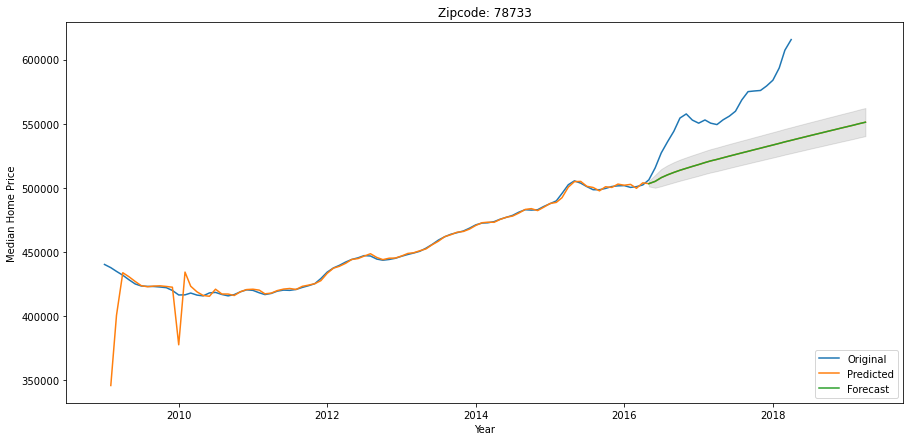

Zipcode: 78733
Explained Variance:
	 0.8639351525910007
MAE:
	 10554.392326159974
RMSE:
	 21808.84939181425
r^2:
	 0.8335752491035484
Expected ROI for 78733: -0.10470588374765992


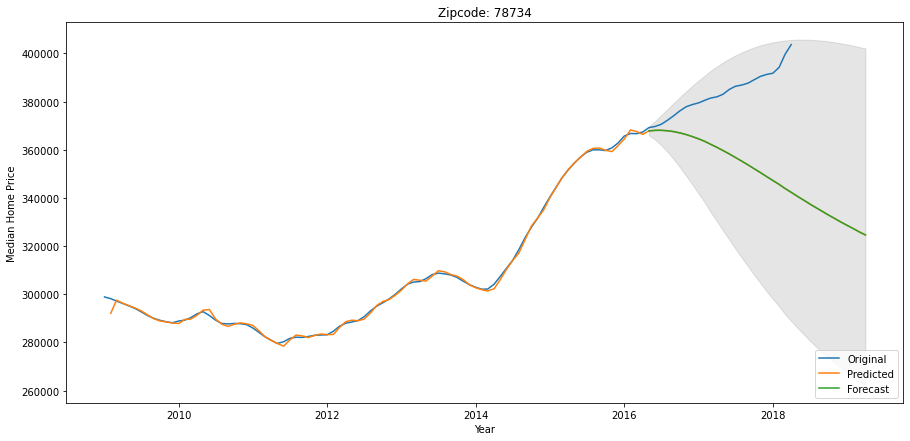

Zipcode: 78734
Explained Variance:
	 0.8906589715022556
MAE:
	 5887.304249425855
RMSE:
	 14121.941920931962
r^2:
	 0.8711940895273869
Expected ROI for 78734: -0.1957899061313176


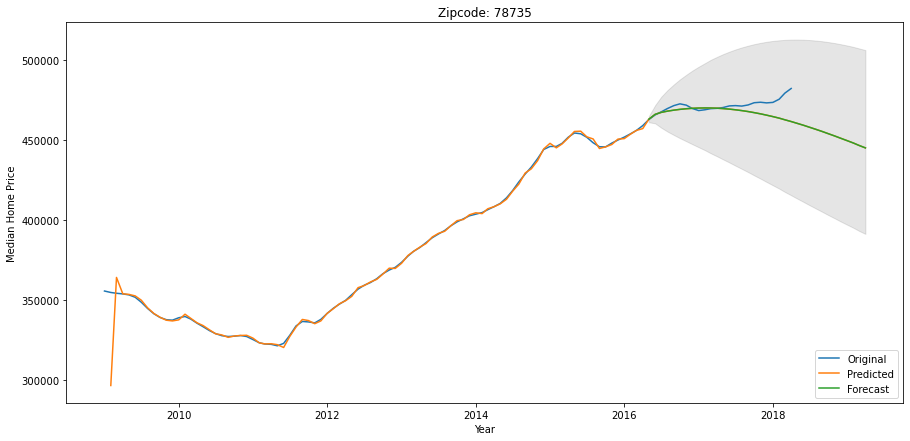

Zipcode: 78735
Explained Variance:
	 0.9869866965401846
MAE:
	 2047.893510394961
RMSE:
	 6486.538066343156
r^2:
	 0.9864421797792959
Expected ROI for 78735: -0.07696552435605493


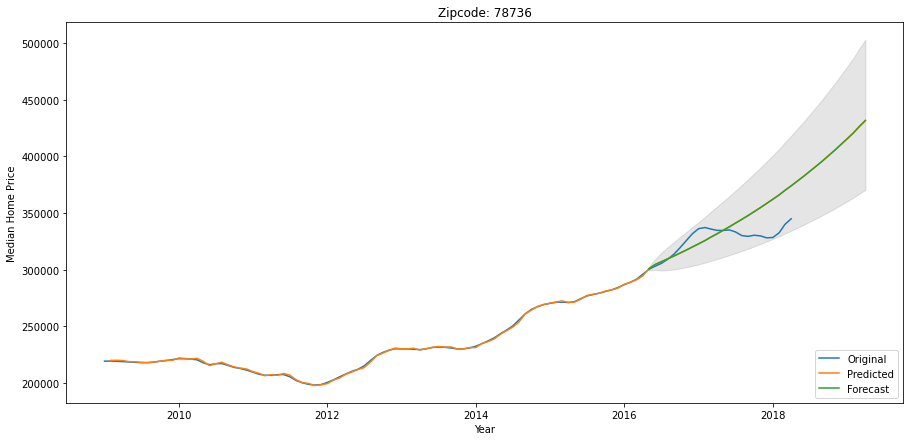

Zipcode: 78736
Explained Variance:
	 0.9700623251484307
MAE:
	 3213.112766376155
RMSE:
	 8070.212869481677
r^2:
	 0.9686476370811585
Expected ROI for 78736: 0.2514237173400873


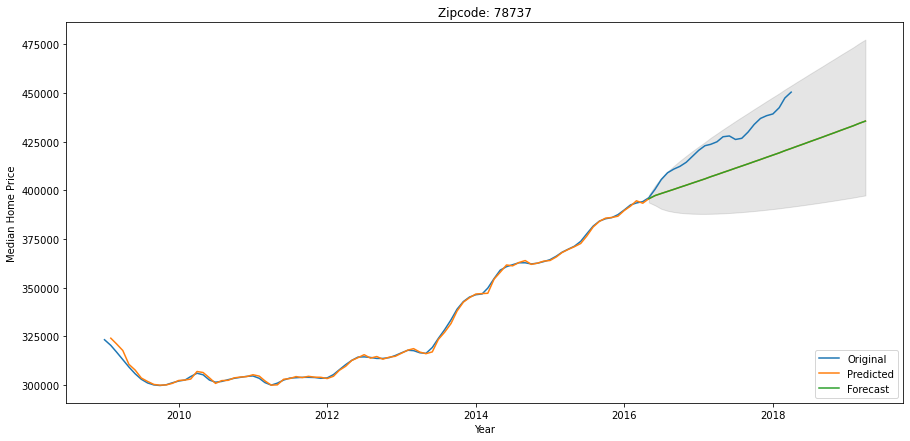

Zipcode: 78737
Explained Variance:
	 0.9771174910565111
MAE:
	 3950.3011641562734
RMSE:
	 7971.4138316802
r^2:
	 0.9723103852577358
Expected ROI for 78737: -0.03299419061972468


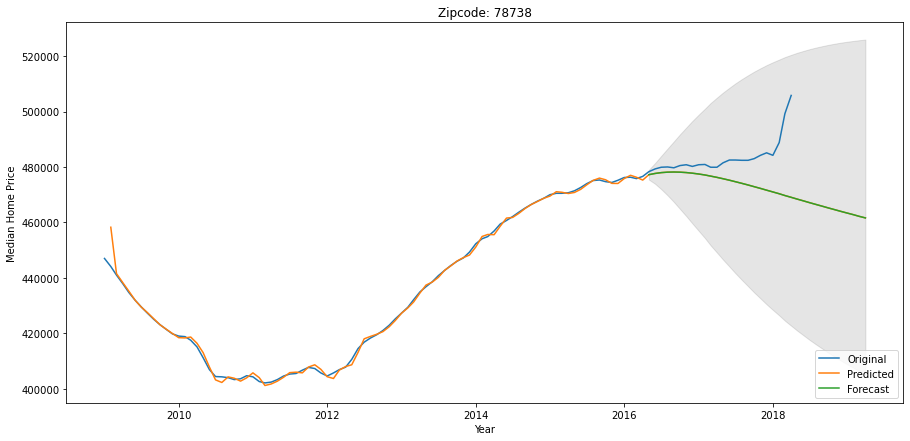

Zipcode: 78738
Explained Variance:
	 0.9666872334283714
MAE:
	 2424.493538275638
RMSE:
	 5847.874318287497
r^2:
	 0.9634273904417615
Expected ROI for 78738: -0.08734496446561174


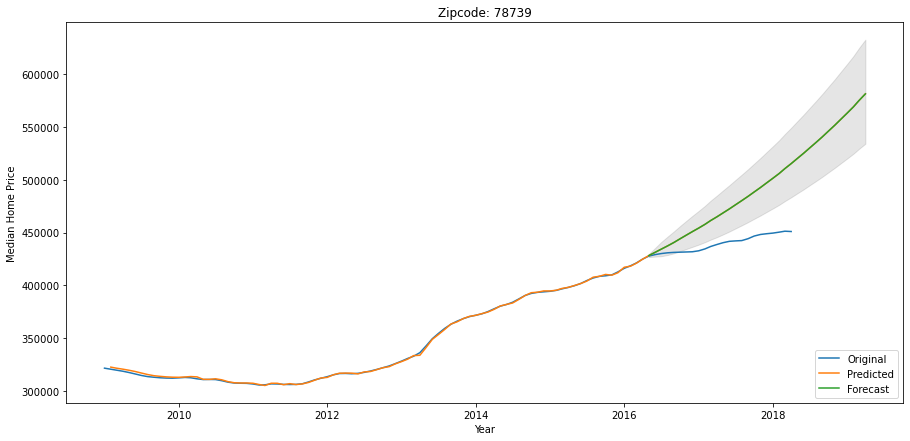

Zipcode: 78739
Explained Variance:
	 0.9209465365433014
MAE:
	 6848.228544038298
RMSE:
	 16104.44187082167
r^2:
	 0.9053906572643593
Expected ROI for 78739: 0.28949597854860554


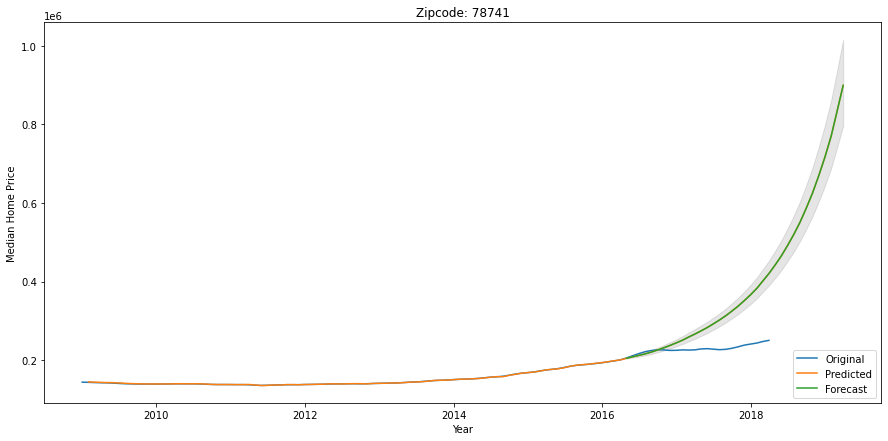

Zipcode: 78741
Explained Variance:
	 0.0994888153699457
MAE:
	 12668.566373330565
RMSE:
	 36295.36482406054
r^2:
	 -0.014808856985905505
Expected ROI for 78741: 2.590583168855371


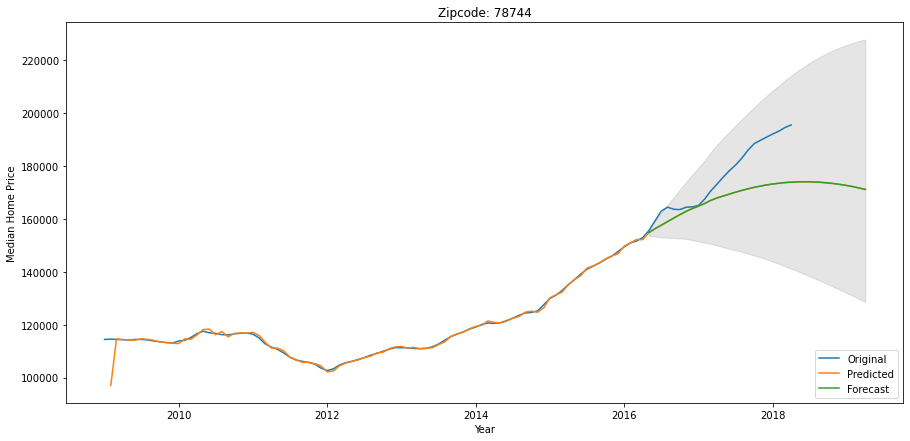

Zipcode: 78744
Explained Variance:
	 0.960439886770315
MAE:
	 2399.0733630868513
RMSE:
	 5693.2353299032175
r^2:
	 0.9541206789017816
Expected ROI for 78744: -0.12477698690357292


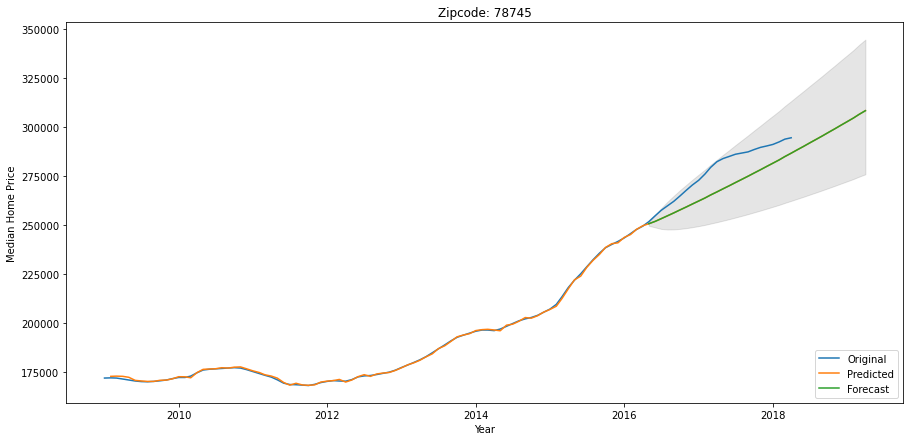

Zipcode: 78745
Explained Variance:
	 0.9887666460879848
MAE:
	 2423.7460216301815
RMSE:
	 4957.0813145879165
r^2:
	 0.9863552565839611
Expected ROI for 78745: 0.04690548737532936


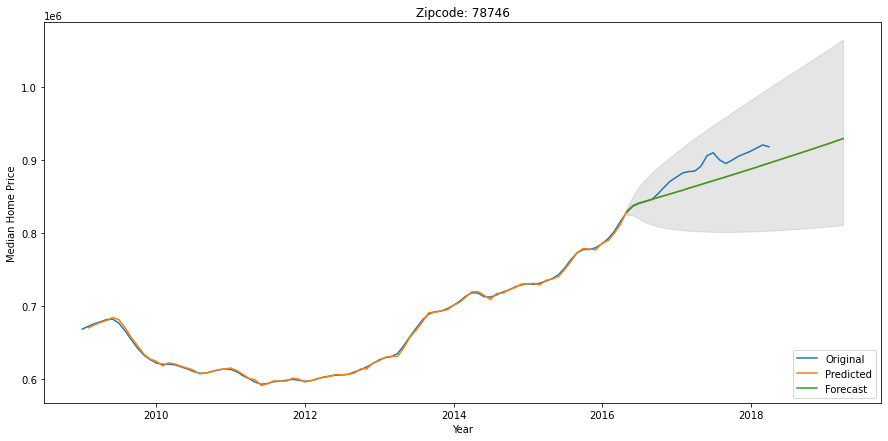

Zipcode: 78746
Explained Variance:
	 0.9923613167293633
MAE:
	 5138.763596629463
RMSE:
	 10063.050371455938
r^2:
	 0.9909910397327109
Expected ROI for 78746: 0.012120147250360485


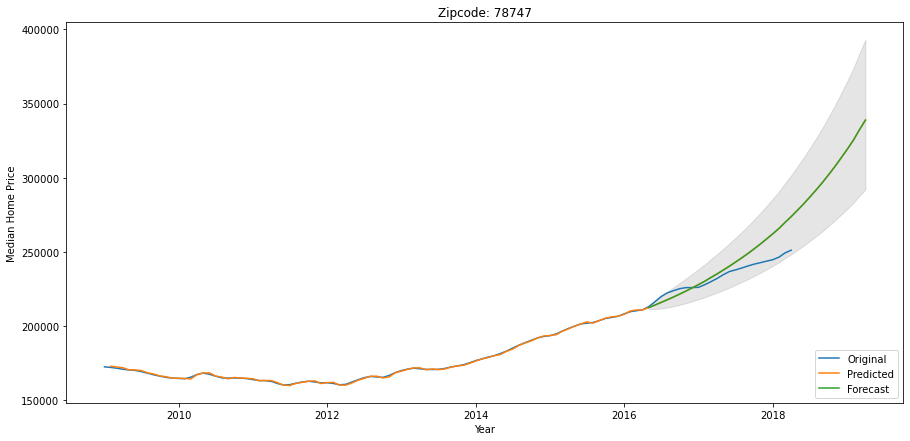

Zipcode: 78747
Explained Variance:
	 0.9736551591975182
MAE:
	 1859.3911456282074
RMSE:
	 4642.248480147489
r^2:
	 0.9717043342533795
Expected ROI for 78747: 0.3489266322126321


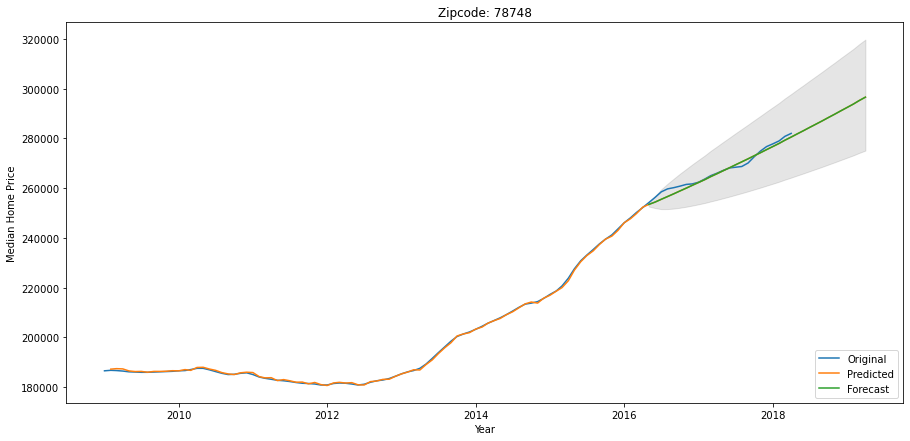

Zipcode: 78748
Explained Variance:
	 0.9995215104386981
MAE:
	 489.64992936776883
RMSE:
	 754.3228035241444
r^2:
	 0.9995014999120071
Expected ROI for 78748: 0.051614260093923676


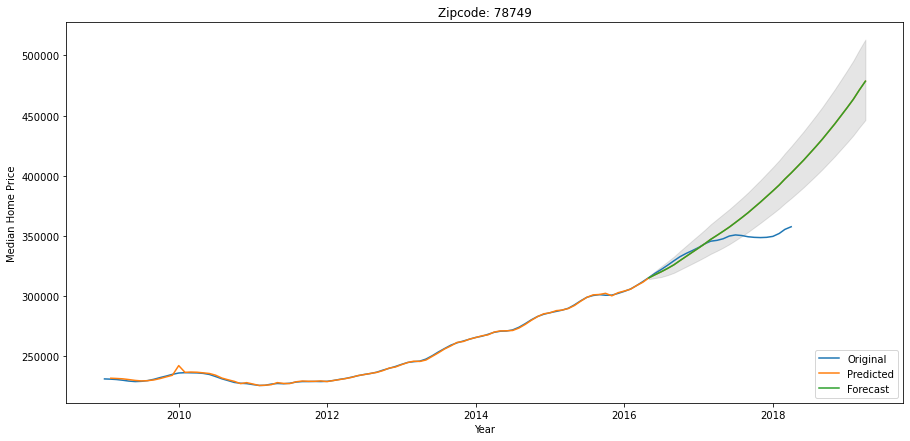

Zipcode: 78749
Explained Variance:
	 0.9559298857992615
MAE:
	 3397.6681724432447
RMSE:
	 9665.113491206861
r^2:
	 0.9518315931638477
Expected ROI for 78749: 0.33795481400286603


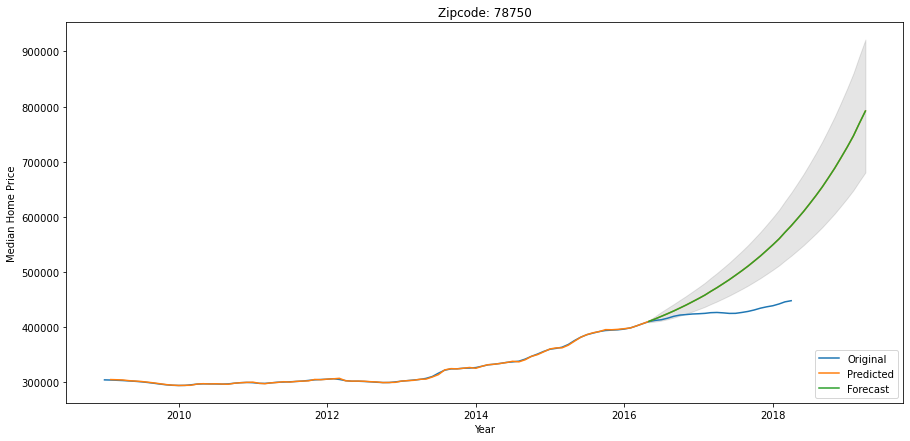

Zipcode: 78750
Explained Variance:
	 0.6635756801550985
MAE:
	 12478.98045868511
RMSE:
	 32608.50382365096
r^2:
	 0.6098960672222263
Expected ROI for 78750: 0.7671760139457814


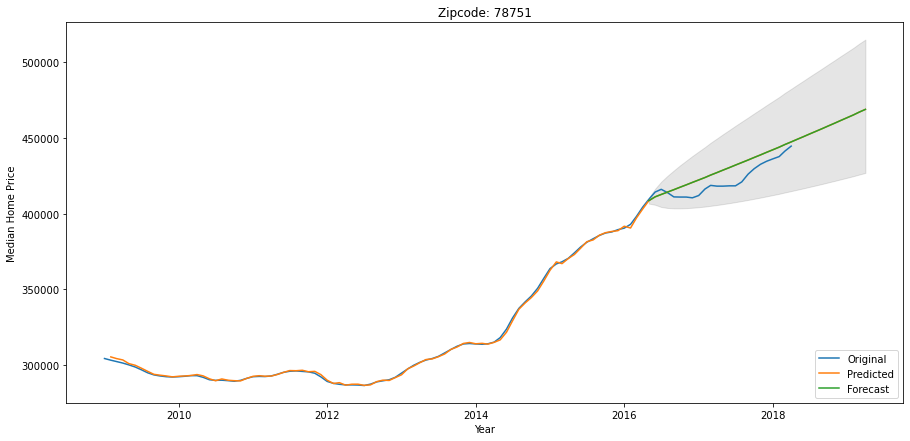

Zipcode: 78751
Explained Variance:
	 0.9958637776394818
MAE:
	 2038.9636324764647
RMSE:
	 3719.511900714531
r^2:
	 0.9951745508421688
Expected ROI for 78751: 0.0545129612645364


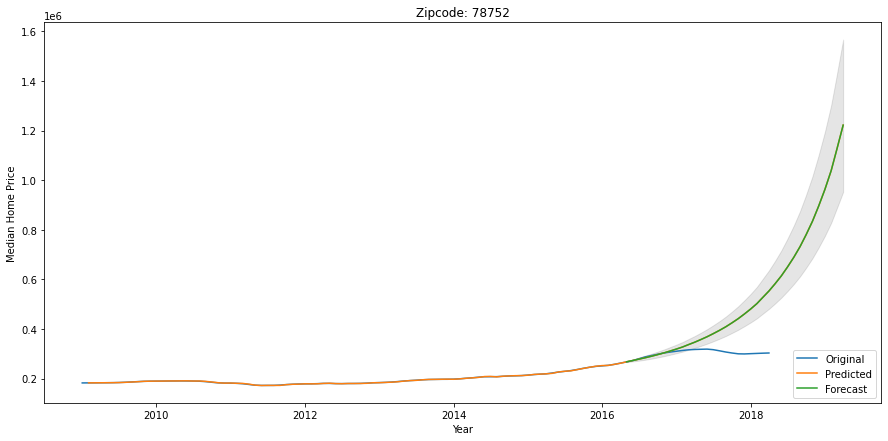

Zipcode: 78752
Explained Variance:
	 0.025279864344909364
MAE:
	 15658.99908143878
RMSE:
	 49610.21095408096
r^2:
	 -0.07556860840827495
Expected ROI for 78752: 3.0312753530243888


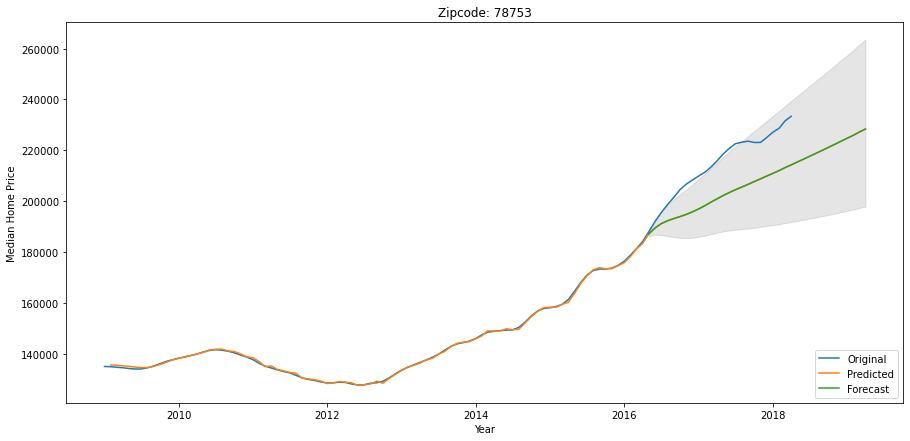

Zipcode: 78753
Explained Variance:
	 0.9668428334508743
MAE:
	 3084.2913402369463
RMSE:
	 6521.1581783878955
r^2:
	 0.9593553011637539
Expected ROI for 78753: -0.02155391018649538


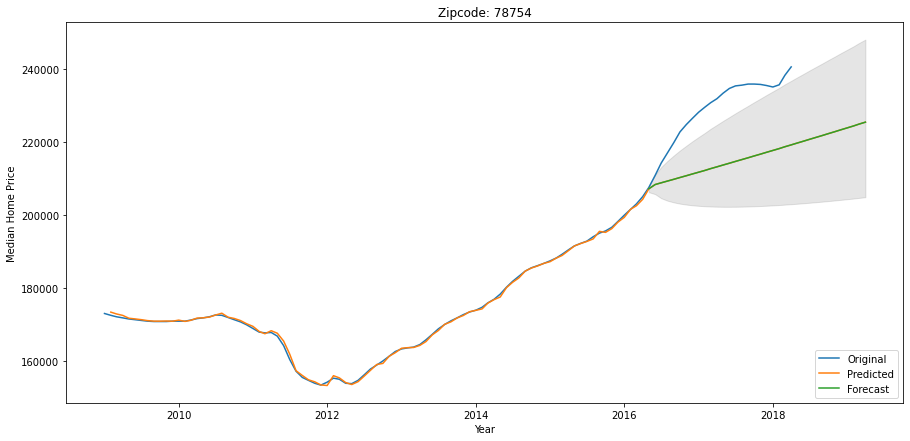

Zipcode: 78754
Explained Variance:
	 0.9283710749613511
MAE:
	 3590.2452542685887
RMSE:
	 7724.600066202065
r^2:
	 0.9118849698615126
Expected ROI for 78754: -0.06286298910891193


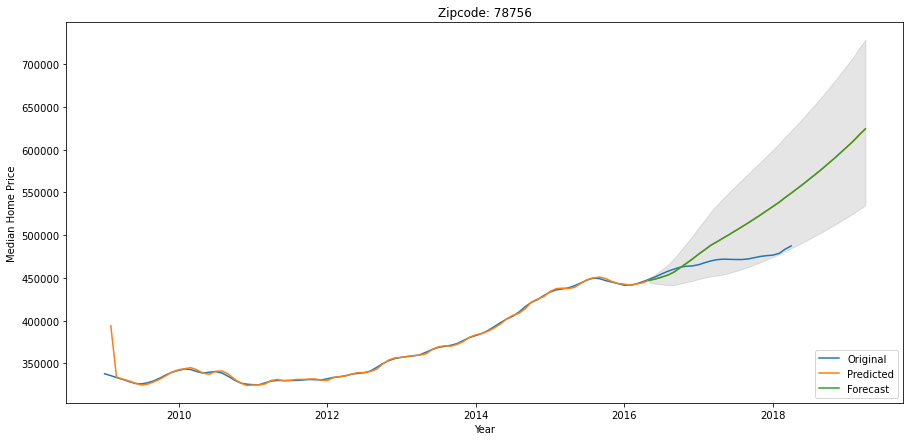

Zipcode: 78756
Explained Variance:
	 0.9208360122361239
MAE:
	 7030.636897435717
RMSE:
	 16992.95945339729
r^2:
	 0.9092558744261492
Expected ROI for 78756: 0.28111341983791993


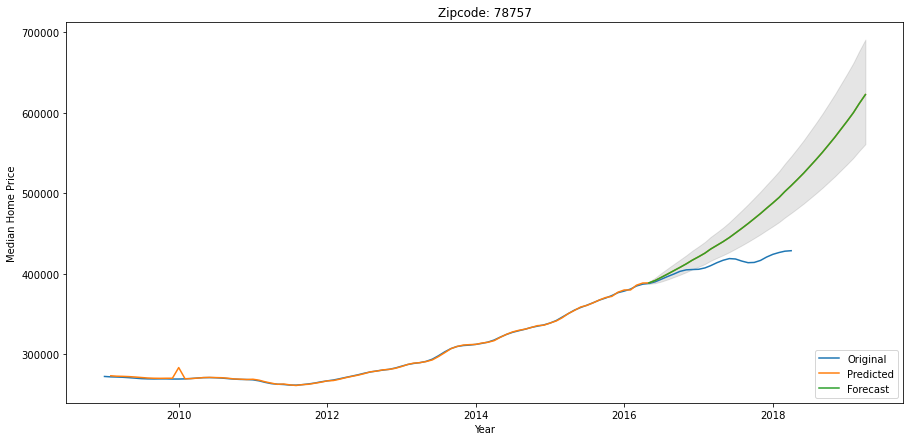

Zipcode: 78757
Explained Variance:
	 0.9071249532093351
MAE:
	 7225.59141503613
RMSE:
	 18779.801835248352
r^2:
	 0.8923867772924201
Expected ROI for 78757: 0.45317960093354576


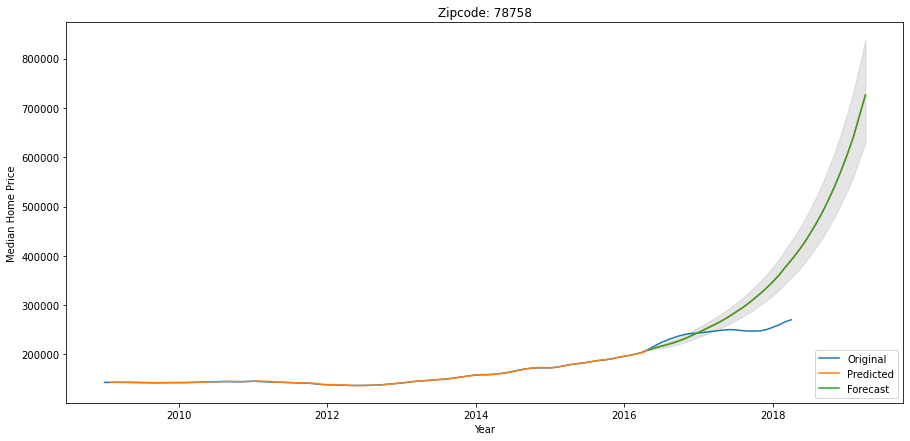

Zipcode: 78758
Explained Variance:
	 0.6484766294186151
MAE:
	 8535.747580339092
RMSE:
	 25280.582662203677
r^2:
	 0.6156682286850557
Expected ROI for 78758: 1.6852887760719044


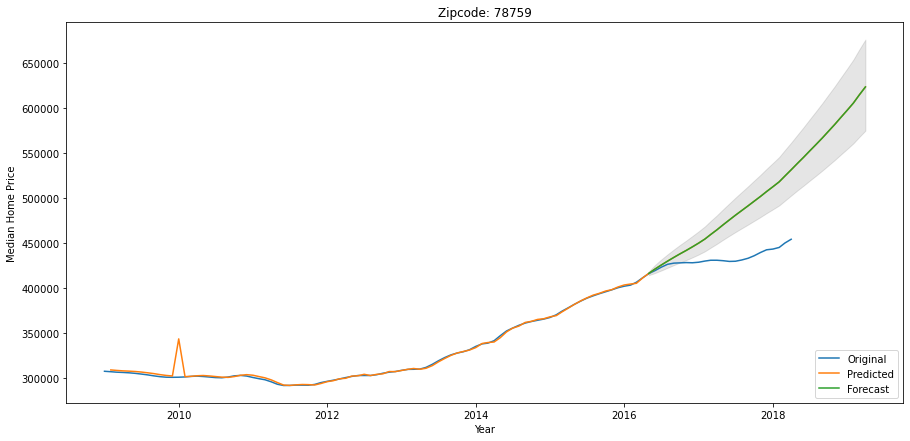

Zipcode: 78759
Explained Variance:
	 0.8670884129999514
MAE:
	 9142.151620064747
RMSE:
	 21551.330859791444
r^2:
	 0.8408545391676232
Expected ROI for 78759: 0.37218842807493707


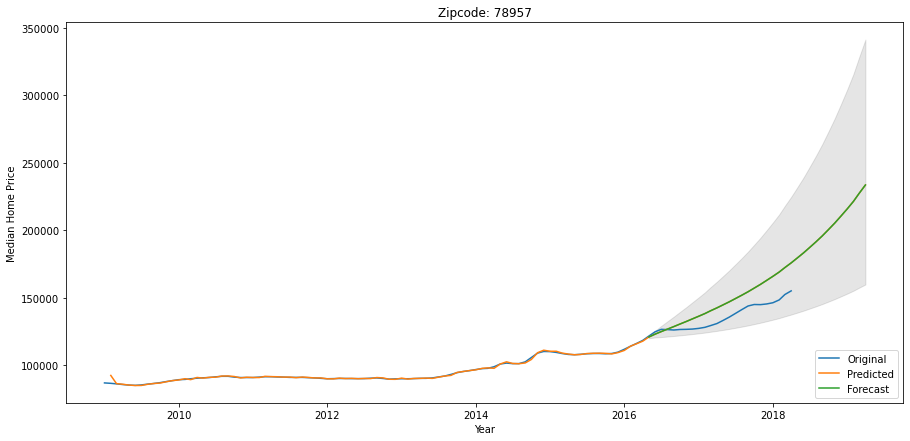

Zipcode: 78957
Explained Variance:
	 0.9228771676163613
MAE:
	 2489.764941392347
RMSE:
	 5637.924094005982
r^2:
	 0.9090207696096753
Expected ROI for 78957: 0.5057434391052051


In [35]:
cutoff = '2016-04-01'

# create a dictionary for explained variance for zipcode
var_dict = {}
# create expected ROI dictionary for each zipcode 1 year into the future
expected_ROI = {}

# run grid search ARIMA for all the zipcodes:
for zipcode in df_final.columns:
    # Train-test split
    train = df_final[zipcode][:cutoff]
    test = df_final[zipcode][cutoff:]
    
    # run grid search ARIMA
    original_series, prediction_series, forecast = run_arima_model(train, 0, 123)
    
    # plot the graph 
    fig, ax = plt.subplots(figsize=(15, 7))
    plt.plot(df_final[zipcode])
    plt.plot(prediction_series[1:])
    plt.plot(forecast['mean'])
    ax.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='k', alpha=0.1);
    plt.title(f'Zipcode: {zipcode}')
    plt.legend(['Original','Predicted', 'Forecast'], loc='lower right')
    plt.xlabel('Year')
    plt.ylabel('Median Home Price')
    plt.show()
    
    # report modeling metrics:
    print(f'Zipcode: {zipcode}')
    report_metrics(df_final[zipcode][1:], prediction_series[1:-12]) 
    
    # store explained variance in the dictionary:
    var_dict[zipcode] = metrics.explained_variance_score(df_final[zipcode][1:], prediction_series[1:-12])
    
    # calculate expected return 1-year into the future:
    expected_ROI[zipcode] = (forecast['mean'][-1] - df_final[zipcode][-1])/df_final[zipcode][-1]
    # 
    print(f'Expected ROI for {zipcode}: {expected_ROI[zipcode]}')
    

## 7. Interpreting Results


We decided to focus on explained variance given that we felt this metric best captures each model’s accuracy, and that this would be most important for our stakeholders. We found that our model was able to account for 99% or more of the explained variance in 13 of the 73 zip codes. 

Thus, our final step was to calculate the predicted ROI for each of these 13 zip codes. We took the top 5 zip codes from this list based on their predicted ROI and used these as our recommendations for our stakeholders. The final step was to calculate the net profit for these five zip codes. Here are the results of our final model:

- 78748: $35,181 (12% ROI)

- 78620: $54,155 (12% ROI)

- 78634: $21,542 (9.6% ROI)

- 78626: $16,826 (7.1% ROI)

- 78756: $31,101 (6.3% ROI)

We also created a df with the longitude/latitude for each zip code along with the predicted ROI. We did the same with the five zip codes from our baseline model. These were used to plot each of these zip codes on a map so that we could see geographically where each of these zip codes were located in order to make more informed recommendations for our stakeholders.


In [36]:
var_dict

{76530: 0.8052101435284958,
 76574: 0.9150859461207981,
 78602: 0.9928713638651823,
 78610: 0.8856604003394347,
 78612: 0.6359136864714385,
 78613: 0.9882972697848397,
 78616: 0.9584201681182234,
 78617: 0.8784516749162834,
 78619: 0.9268186894760558,
 78620: 0.6278042337961747,
 78621: 0.8874781506903482,
 78626: 0.9982784729589392,
 78628: 0.7509149470212113,
 78633: 0.9951849072088487,
 78634: 0.9586700724603664,
 78640: 0.8646392995561081,
 78641: 0.8488710165989296,
 78642: 0.9653040698069566,
 78644: 0.9895483827610728,
 78645: 0.9562696656716536,
 78648: 0.974933885572519,
 78652: 0.9872113068534275,
 78653: 0.24022260850736588,
 78655: 0.8504725882351098,
 78659: -2.518180511904162,
 78660: 0.7797279953673667,
 78664: 0.9804725483606456,
 78665: 0.9975879141956748,
 78666: 0.7927427434900113,
 78669: 0.7968328464374536,
 78676: 0.8622219902044004,
 78681: 0.9690708306867576,
 78702: 0.9891548678855392,
 78703: 0.995032879641205,
 78704: 0.9873633277391345,
 78705: 0.96437121388

In [37]:
# Choose zipcodes which have 99% explained varriance: 
top_zipcodes = []
for (key, value) in var_dict.items():
    if value > 0.99:
        top_zipcodes.append(key)

top_zipcodes

[78602, 78626, 78633, 78665, 78703, 78723, 78729, 78746, 78748, 78751]

In [38]:
# Print out the expected ROI of the investment suggestions:
for i in top_zipcodes:
    print(f'{i}: Expected ROI for one-year is {round(expected_ROI[i]*100, 2)}%')

78602: Expected ROI for one-year is 9.56%
78626: Expected ROI for one-year is 10.46%
78633: Expected ROI for one-year is 5.23%
78665: Expected ROI for one-year is 1.55%
78703: Expected ROI for one-year is 5.07%
78723: Expected ROI for one-year is 5.4%
78729: Expected ROI for one-year is 4.87%
78746: Expected ROI for one-year is 1.21%
78748: Expected ROI for one-year is 5.16%
78751: Expected ROI for one-year is 5.45%


In [39]:
# Construct final recommendations df to make visualizations:
Recommendations = pd.DataFrame()
Recommendations['zipcode'] = [78748, 78620, 78634, 78626, 78756]
Recommendations['ROI'] = [12.48, 12.34, 9.68, 7.14, 6.38]

cumsum = []
long = []
lat = []
for i in Recommendations['zipcode']:
    long.append(zcdb[i].longitude)
    lat.append(zcdb[i].latitude)
    cumsum.append(df_return[i].cumsum()[-1])

Recommendations['Longitude'] =long
Recommendations['Latitude']=lat
Recommendations['CumulativeReturn'] = cumsum
Recommendations['CumulativeReturn(%)'] = Recommendations['CumulativeReturn']*100
Recommendations['AverageYearlyReturn(%)'] = Recommendations['CumulativeReturn']*100/9 # We have 9 years in our data

Recommendations

zipcode    ROI  Longitude   Latitude  CumulativeReturn  \
0    78748  12.48  -97.82265  30.172020          0.414836   
1    78620  12.34  -98.10753  30.241080          0.427481   
2    78634   9.68  -97.54611  30.540874          0.377009   
3    78626   7.14  -97.64713  30.643058          0.409885   
4    78756   6.38  -97.74177  30.320206          0.368966   

   CumulativeReturn(%)  AverageYearlyReturn(%)  
0            41.483590                4.609288  
1            42.748065                4.749785  
2            37.700895                4.188988  
3            40.988535                4.554282  
4            36.896646                4.099627

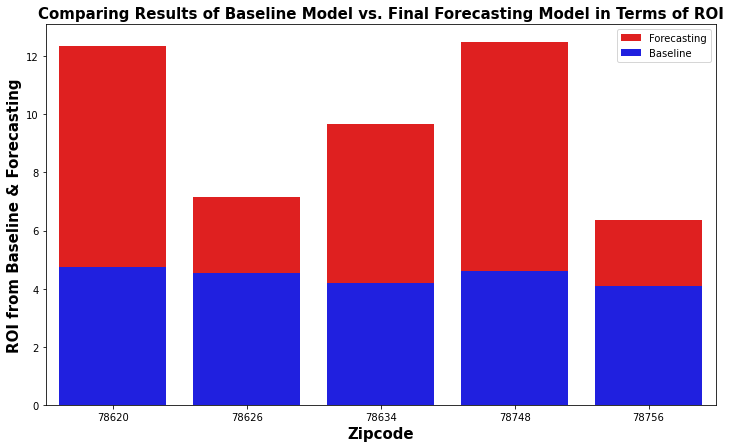

In [44]:
# Comparing top 5 Zipcodes prior to modeling (Average Yearly Return) and after modeling (predicted ROI)
fig, ax = plt.subplots(figsize=(12,7))

ax1 = sns.barplot(data=Recommendations, x="zipcode", y='ROI', color='red', label='Forecasting')
ax2 = sns.barplot(data=Recommendations, x="zipcode", y='AverageYearlyReturn(%)', color='blue', label='Baseline')
plt.title('Comparing Results of Baseline Model vs. Final Forecasting Model in Terms of ROI', fontsize=15, fontweight='bold')
plt.ylabel('ROI from Baseline & Forecasting', fontsize=15, fontweight='bold')
plt.xlabel('Zipcode', fontsize=15, fontweight='bold')
plt.legend()
plt.savefig('Final_Chart');

In [41]:
# Median house price for the suggested investment zip codes:
fig = px.line(df_final[Recommendations['zipcode']], title='Median House Prices')
fig.show()

In [42]:
# Explore relationship between expected_ROI and location
fig = px.scatter_mapbox(data_frame = Recommendations, # df name
                        lat='Latitude', # name of latitude column
                        lon='Longitude', # name of longitude column
                        zoom=8.5,
                        color='ROI',
                        size='ROI')

fig.update_layout(mapbox_style="open-street-map")
fig.show()

## 8. Conclusions 

Our final time series forecast model produced better ROI than our baseline model for all five of our zip code recommendations. We are confident in these predictions given that our model accounted for 99% or more of the explained variance in each of these zip codes. These results are further bolstered by the use of a train-test split, which helps prevent overfitting. 

Given these results, here are our recommendations to the stakeholders:
- These five zip codes represent good potential investments for the upcoming year based on ROI. 
- One thing to keep in mind is that the median value for each zip code is different. Thus, we recommend our stakeholders take these relative amounts into account when deciding where to invest. For example, our model predicts that 78756 will produce the largest amount of net profit, but the median housing price in this zip code is close to \\$500K. On the other hand, 78748 is closer to \\$300K but has almost double the predicted ROI compared to 78756 (12% vs. 6.3%). In other words, investing in 78748 will potentially produce higher ROI and net profit than 78756 with a smaller initial investment rate.
- Our baseline model demonstrated that 4 of the top 5 zip codes from 2009–2018 were in the downtown ATX area, but our final model suggests that 4 of the top 5 zip codes in the next year will be in the ATX suburbs. This is perhaps not too surprising, given that the continual expansion of the city means that there are more investment opportunities outside of downtown. We want our stakeholders to be aware of these geographical differences when making their investments. 


## 9. Limitations & Future Directions

- Our dataset only goes through April 2018, which does not take more current prices into account. This also does not take the effects of the COVID pandemic into account. 
- Given that this dataset only includes median sales prices for each zip code, our model does not account for more granular trends (e.g. neighborhoods, individual homes, etc.). 
- If we wanted to calculate the ROI and/or net profit for individual homes, we would need data for each house in the dataset, so this report is more of a general representation than a specific analysis for each investment. 
- This dataset only includes sale prices for each zip code. While this is important for our predictions, other features such as crime rates, quality of schools, quality of neighborhood, etc. is not included. Thus, there could be other contributing factors to these sale prices that our model is not taking into account.
- We feel very confident about the results of the 13 zip codes for which our model was able to account for 99% or higher explained variance. However, if we wanted to achieve similar results for all 73 zip codes, we could try running our data through a Long Short-Term Memory (LTSM) neural network, given that they are effective for order dependent data sets.